# Barcode diversity quantification

Jupyter notebook containing analyses for quantifying barcode diversity for libraries from Shin & Urbanek. 

The notebook contains four types of analyses:
1) %UMI knee plots, which visualize the percentage of UMIs for each library taken up by a single barcode.
2) %Barcode collision, which visualizes the percent of overlapping barcodes as a function of barcodes randomly drawn from the diversity library (with replacement).
3) Unique barcodes sampled, which visualizes the number of unique barcodes identified when randomly selecting x barcodes from a library (with replacement).
4) Barcode entropy, which quanitifes the amount of encodable information contained in a given barcode library.

Input for this notebook requires:
1) Viral diversity libraries, which at a minimum, must contain a column with the unique barcode sequence ('barcode') and the number of UMIs counted per barcode.

Output for this notebook includes:
1) Plots for each of analyses described above

Module and their versions used when generating figures for the paper can be found in 'requirements.txt', which is stored in our GitHub repository: https://github.com/MEUrbanek/rabies_barcode_tech

This code was last amended by Maddie Urbanek on 12/12/2025

## Notebook set-up

In [58]:
#Font settings
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [59]:
#Load in modules:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as scipy
from itertools import product 
import seaborn as sns
from statsmodels.multivariate.manova import MANOVA
from scipy import stats as st
from scipy.stats import binomtest
from scipy.stats import entropy
from scipy.stats import binom

In [60]:
#Set working directory to point to barcode diversity libraries
import os
os.chdir('/Users/maddieurbanek/Desktop/revision_data/resubmission/data/barcode_diversity_libraries/')  

## Import data

In [61]:
#SADB19 libraries
rep_1=pd.read_table('./sadb19/rep_1.tsv',delimiter='\t')
rep_2=pd.read_table('./sadb19/rep_2.tsv',delimiter='\t')
rep_3=pd.read_table('./sadb19/rep_3.csv',delimiter=',')

In [62]:
#CVS-N2c libraries
rep_4=pd.read_table('./cvs/rep_4.tsv',delimiter='\t')
rep_5=pd.read_table('./cvs/rep_5.tsv',delimiter='\t')

In [63]:
#Previously published libraries
zhang=pd.read_table('./previous_studies/zhang_completecounts.csv',delimiter=',')
clark=pd.read_table('./previous_studies/clark_completecounts.tsv',delimiter='\t')
saunders=pd.read_table('./previous_studies/saunders_original_counts.csv',delimiter=',')

In [73]:
#Tan libraries
tan_cvs=pd.read_table('./previous_studies/tan_cvs_completecounts.csv',delimiter=',')
tan_sad=pd.read_table('./previous_studies/tan_sad_completecounts.csv',delimiter=',')

tan_cvs.rename(columns={'barcodes': 'barcode', 'counts': 'UMI_Count'}, inplace=True)
tan_sad.rename(columns={'barcodes': 'barcode', 'counts': 'UMI_Count'}, inplace=True)

In [116]:
#Plasmid libraries
sadb19_plasmid=pd.read_table('./sadb19/sadb19_plasmid.tsv',delimiter='\t')
cvs_plasmid=pd.read_table('./cvs/cvs_plasmid.tsv',delimiter='\t')

In [117]:
#Lipofectamine comparison libraries
l2_1=pd.read_table('./transfection_comparisons/lipofectamine2000_1.tsv',delimiter='\t')
l2_2=pd.read_table('./transfection_comparisons/lipofectamine2000_2.tsv',delimiter='\t')
l2_3=pd.read_table('./transfection_comparisons/lipofectamine2000_3.tsv',delimiter='\t')
l2_4=pd.read_table('./transfection_comparisons/lipofectamine2000_4.tsv',delimiter='\t')

l3_1=pd.read_table('./transfection_comparisons/lipofectamine3000_1.tsv',delimiter='\t')
l3_2=pd.read_table('./transfection_comparisons/lipofectamine3000_2.tsv',delimiter='\t')
l3_3=pd.read_table('./transfection_comparisons/lipofectamine3000_3.tsv',delimiter='\t')
l3_4=pd.read_table('./transfection_comparisons/lipofectamine3000_4.tsv',delimiter='\t')

In [118]:
#Cell line comparison libraries
hekgt_1=pd.read_table('./cell_comparisons/hekgt_1.tsv',delimiter='\t')
hekgt_2=pd.read_table('./cell_comparisons/hekgt_2.tsv',delimiter='\t')
hekgt_3=pd.read_table('./cell_comparisons/hekgt_3.tsv',delimiter='\t')
hekgt_4=pd.read_table('./cell_comparisons/hekgt_4.tsv',delimiter='\t')

hek293t_1=pd.read_table('./cell_comparisons/hek293t_1.tsv',delimiter='\t')
hek293t_2=pd.read_table('./cell_comparisons/hek293t_2.tsv',delimiter='\t')
hek293t_3=pd.read_table('./cell_comparisons/hek293t_3.tsv',delimiter='\t')
hek293t_4=pd.read_table('./cell_comparisons/hek293t_4.tsv',delimiter='\t')

In [119]:
#Clonal comparison libraries
c1r2=pd.read_table('./clone_comparisons/c1r2_completecounts.tsv',delimiter='\t')
c1r3=pd.read_table('./clone_comparisons/c1r3_completecounts.tsv',delimiter='\t')

c2r2=pd.read_table('./clone_comparisons/c2r2_completecounts.tsv',delimiter='\t')
c2r3=pd.read_table('./clone_comparisons/c2r3_completecounts.tsv',delimiter='\t')

c3r2=pd.read_table('./clone_comparisons/c3r2_completecounts.tsv',delimiter='\t')
c3r3=pd.read_table('./clone_comparisons/c3r3_completecounts.tsv',delimiter='\t')

c4r2=pd.read_table('./clone_comparisons/c4r2_completecounts.tsv',delimiter='\t')
c4r3=pd.read_table('./clone_comparisons/c4r3_completecounts.tsv',delimiter='\t')

pr2=pd.read_table('./clone_comparisons/pr2_completecounts.tsv',delimiter='\t')
pr3=pd.read_table('./clone_comparisons/pr3_completecounts.tsv',delimiter='\t')

In [120]:
#Plate size comparison libraries
cm15=pd.read_table('./plate_comparisons/15_completecounts.tsv',delimiter='\t')
well384=pd.read_table('./plate_comparisons/384_completecounts.tsv',delimiter='\t')

In [65]:
#Randomer
randomer=pd.read_table('./cvs/collapsed_randomer.tsv',delimiter='\t')

## Data formatting

All data needs to have a barcode column with the unique barcode sequence and a paired column with the total UMI counts identified in the library for that unique barcode. Data coming from previously published studies requires some reformatting to streamline the rest of the analysis.

In [66]:
#Reformat Saunders dataset
saunders = saunders.loc[saunders.index.repeat(saunders['n_count'])].reset_index(drop=True)
saunders['barcode'] = saunders.index
saunders.drop(['n_count'],axis=1)
umis = saunders.loc[saunders.index.repeat(saunders['n_unique_umibc_pairs'])].reset_index(drop=True)
saunders=umis.drop(['n_count','n_unique_umibc_pairs'], axis=1)
saunders=pd.DataFrame(saunders)
saunders=saunders['barcode'].value_counts().reset_index()
saunders.columns=['barcode','UMI_Count']

#Export reformatted counts matrix for easy loading if needed
saunders.to_csv('./previous_studies/saunders_completecounts.csv')
saunders

,barcode,UMI_Count
0,1293510,73967
1,1293509,58453
2,1293508,57649
3,1293507,38478
4,1293506,37200
...,...,...
1293506,431170,1
1293507,431169,1
1293508,431168,1
1293509,431167,1


Some data also comes from pooled libraries, where there may be some barcode sequences that appear in multiple rows, without summed UMIs. To collapse those libraries, use the following function.

In [67]:
def collapse_pooled(dataset #the dataframe above including barcodes and UMI counts
                   ):

    #Collapsed any barcodes that are identical across pooled datasets
    temp = dataset.loc[dataset.index.repeat(dataset['UMI_Count'])].reset_index(drop=True)
    temp=temp['barcode'].value_counts()
    temp=pd.DataFrame(temp)
    dataset = temp.rename_axis('barcode').reset_index()
    dataset.columns=['barcode','UMI_Count']

    return dataset

In [68]:
#Run pooled datasets through collapse_pooled function to verify that all individual barcodes have been collapsed and their UMIs summed
rep_1=collapse_pooled(rep_1)
rep_2=collapse_pooled(rep_2)
rep_3=collapse_pooled(rep_3)
rep_4=collapse_pooled(rep_4)
rep_5=collapse_pooled(rep_5)

In [69]:
#Export collapsed libraries that were used for slice experiments to .csv files for input into connectivity pipeline
rep_3.to_csv('/Users/maddieurbanek/Desktop/revision_data/resubmission/data/barcode_diversity_libraries/used_in_experiments/sad_rep.csv')
rep_5.to_csv('/Users/maddieurbanek/Desktop/revision_data/resubmission/data/barcode_diversity_libraries/used_in_experiments/cvs_rep.csv')

## %UMI knee plots

### Build function for calculating and plotting %UMI per dataset

In [71]:
def percent_umi(dataset #the properly formatted dataframe above including barcodes and UMI counts
               ):
    
    dataset['%UMI']=(dataset['UMI_Count']/(dataset['UMI_Count'].sum()))*100
    dataset_s=dataset.sort_values(by='%UMI',ascending=False)
    dataset=dataset_s.reset_index()
    dataset['rank']=dataset.index

    return dataset

### Apply function to datasets of interest and plot:

##### Replicates and previously published datasets

In [72]:
#For Figure 1, process our main replicates and previously published studies
rep_1=percent_umi(rep_1)
rep_2=percent_umi(rep_2)
rep_3=percent_umi(rep_3)
rep_4=percent_umi(rep_4)
rep_5=percent_umi(rep_5)
randomer=percent_umi(randomer)

clark=percent_umi(clark)
saunders=percent_umi(saunders)
zhang=percent_umi(zhang)

tan_cvs=percent_umi(tan_cvs)
tan_sad=percent_umi(tan_sad)

KeyError: 'UMI_Count'

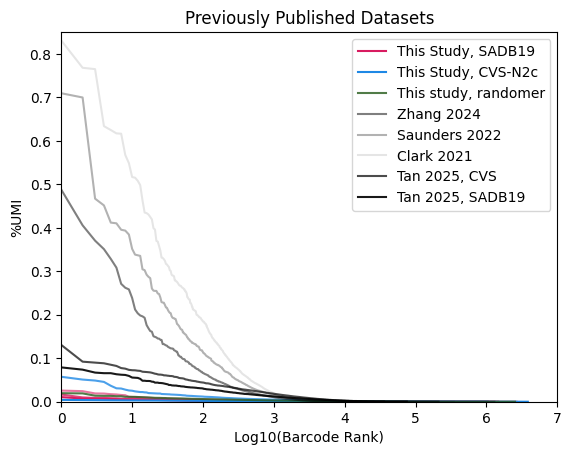

In [78]:
#Plot
plt.plot(np.log10(rep_1['rank']),rep_1['%UMI'],label = "This Study, SADB19",color = '#D81B60',linewidth=1.5)
plt.plot(np.log10(rep_2['rank']),rep_2['%UMI'],color = '#D81B60',linewidth=1.5,alpha=0.8)
plt.plot(np.log10(rep_3['rank']),rep_3['%UMI'],color = '#D81B60',linewidth=1.5,alpha=0.6)

plt.plot(np.log10(rep_4['rank']),rep_4['%UMI'],label = "This Study, CVS-N2c",color = '#1E88E5',linewidth=1.5)
plt.plot(np.log10(rep_5['rank']),rep_5['%UMI'],color = '#1E88E5',linewidth=1.5,alpha=0.8)

plt.plot(np.log10(randomer['rank']),randomer['%UMI'],label= "This study, randomer", color = '#265B1A',linewidth=1.5,alpha=0.8)

plt.plot(np.log10(zhang['rank']),zhang['%UMI'],label = "Zhang 2024",color = 'black',linewidth=1.5,alpha=0.5)
plt.plot(np.log10(saunders['rank']),saunders['%UMI'],label = "Saunders 2022",color = 'black',linewidth=1.5,alpha=0.3)
plt.plot(np.log10(clark['rank']),clark['%UMI'],label = "Clark 2021",color = 'black',linewidth=1.5,alpha=0.1)

plt.plot(np.log10(tan_cvs['rank']),tan_cvs['%UMI'],label = "Tan 2025, CVS",color = 'black',linewidth=1.5,alpha=0.7)
plt.plot(np.log10(tan_sad['rank']),tan_sad['%UMI'],label = "Tan 2025, SADB19",color = 'black',linewidth=1.5,alpha=0.9)

plt.xlabel("Log10(Barcode Rank)")
plt.ylabel("%UMI")
plt.title("Previously Published Datasets")
#plt.yscale('log')
#plt.legend(loc='upper right')
# Adding legend, which helps us recognize the curve according to it's color
plt.axis([0, 7, 0, 0.85])
plt.legend(loc='upper right')
plt.draw()
plt.savefig("../../figs/fig_1/percent_umi.pdf",bbox_inches='tight', format='pdf')
plt.show()

/var/folders/5l/rz29hct17d916rns_lvv75dw0000gn/T/ipykernel_88338/3997868855.py:25: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.axis([0, 7, 0, 0.85])


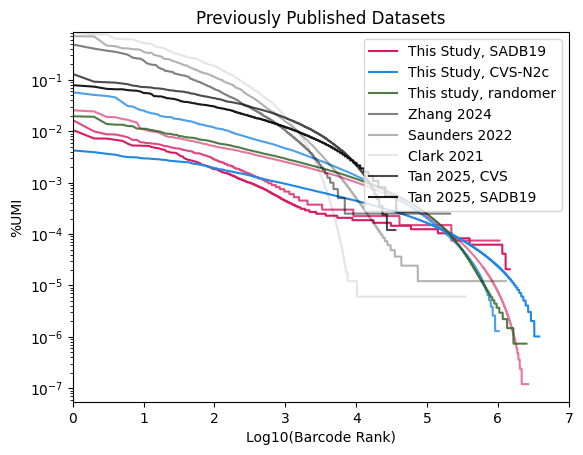

In [79]:
#Plot with log-scaled y-axis
#Plot
plt.plot(np.log10(rep_1['rank']),rep_1['%UMI'],label = "This Study, SADB19",color = '#D81B60',linewidth=1.5)
plt.plot(np.log10(rep_2['rank']),rep_2['%UMI'],color = '#D81B60',linewidth=1.5,alpha=0.8)
plt.plot(np.log10(rep_3['rank']),rep_3['%UMI'],color = '#D81B60',linewidth=1.5,alpha=0.6)

plt.plot(np.log10(rep_4['rank']),rep_4['%UMI'],label = "This Study, CVS-N2c",color = '#1E88E5',linewidth=1.5)
plt.plot(np.log10(rep_5['rank']),rep_5['%UMI'],color = '#1E88E5',linewidth=1.5,alpha=0.8)

plt.plot(np.log10(randomer['rank']),randomer['%UMI'],label= "This study, randomer", color = '#265B1A',linewidth=1.5,alpha=0.8)

plt.plot(np.log10(zhang['rank']),zhang['%UMI'],label = "Zhang 2024",color = 'black',linewidth=1.5,alpha=0.5)
plt.plot(np.log10(saunders['rank']),saunders['%UMI'],label = "Saunders 2022",color = 'black',linewidth=1.5,alpha=0.3)
plt.plot(np.log10(clark['rank']),clark['%UMI'],label = "Clark 2021",color = 'black',linewidth=1.5,alpha=0.1)

plt.plot(np.log10(tan_cvs['rank']),tan_cvs['%UMI'],label = "Tan 2025, CVS",color = 'black',linewidth=1.5,alpha=0.7)
plt.plot(np.log10(tan_sad['rank']),tan_sad['%UMI'],label = "Tan 2025, SADB19",color = 'black',linewidth=1.5,alpha=0.9)

plt.xlabel("Log10(Barcode Rank)")
plt.ylabel("%UMI")
plt.title("Previously Published Datasets")
plt.yscale('log')
#plt.legend(loc='upper right')
# Adding legend, which helps us recognize the curve according to it's color
plt.axis([0, 7, 0, 0.85])
plt.legend(loc='upper right')
plt.draw()
plt.savefig("../../figs/fig_1/log_percent_umi.pdf",bbox_inches='tight', format='pdf')
plt.show()

##### Plasmid libraries

In [ ]:
#For Extended data 1, process our the plasmid libraries used for the bit-based SADB19 and CVS-N2c libraries
sadb19_plasmid=percent_umi(sadb19_plasmid)
cvs_plasmid=percent_umi(cvs_plasmid)

In [ ]:
#Plot
plt.plot(np.log10(sadb19_plasmid['rank']),sadb19_plasmid['%UMI'],label = "SADB19",color = '#882255',linewidth=1.5)
plt.plot(np.log10(cvs_plasmid['rank']),cvs_plasmid['%UMI'],label = 'CVS-N2c',linewidth=1.5,alpha=0.8)

plt.xlabel("Log10(Barcode Rank)")
plt.ylabel("%UMI")
plt.title("Plasmids")
#plt.yscale('log')
#plt.legend(loc='upper right')
# Adding legend, which helps us recognize the curve according to it's color
plt.axis([0, 8, 0, 0.0020])
plt.legend(loc='upper right')
plt.draw()
plt.savefig("../../figs/sfig_1/plasmid_percent_umi.pdf",bbox_inches='tight', format='pdf')
plt.show()

##### Lipofectamine comparison

In [ ]:
#For figure 2, process the lipofectamine2000 vs. 3000 datasets
l2_1=percent_umi(l2_1)
l2_2=percent_umi(l2_2)
l2_3=percent_umi(l2_3)
l2_4=percent_umi(l2_4)

l3_1=percent_umi(l3_1)
l3_2=percent_umi(l3_2)
l3_3=percent_umi(l3_3)
l3_4=percent_umi(l3_4)

In [ ]:
#Plot
plt.plot(np.log10(l3_1['rank']),l3_1['%UMI'],label = "Lipo3000",color = '#882255',linewidth=1.5)
plt.plot(np.log10(l3_2['rank']),l3_2['%UMI'],label = "Lipo3000",color = '#882255',linewidth=1.5,alpha=0.8)
plt.plot(np.log10(l3_3['rank']),l3_3['%UMI'],label = "Lipo3000",color = '#882255',linewidth=1.5,alpha=0.6)
plt.plot(np.log10(l3_4['rank']),l3_4['%UMI'],label = "Lipo3000",color = '#882255',linewidth=1.5,alpha=0.4)

plt.plot(np.log10(l2_1['rank']),l2_1['%UMI'],label = "Lipo2000",color = 'blue',linewidth=1.5)
plt.plot(np.log10(l2_2['rank']),l2_2['%UMI'],label = "Lipo2000",color = 'blue',linewidth=1.5,alpha=0.8)
plt.plot(np.log10(l2_3['rank']),l2_3['%UMI'],label = "Lipo2000",color = 'blue',linewidth=1.5,alpha=0.6)
plt.plot(np.log10(l2_4['rank']),l2_4['%UMI'],label = "Lipo2000",color = 'blue',linewidth=1.5,alpha=0.4)


plt.xlabel("Log10(Barcode Rank)")
plt.ylabel("%UMI")
plt.title("Transfection Reagents")
#plt.yscale('log')
#plt.legend(loc='upper right')
# Adding legend, which helps us recognize the curve according to it's color
plt.axis([0, 7, 0, 2.75])
plt.legend(loc='upper right')
plt.draw()
plt.savefig("../../figs/fig_2/transfection_percent_umi.pdf",bbox_inches='tight', format='pdf')
plt.show()

##### Cell line comparison

In [ ]:
#For figure 2, process the HEK-GT vs. HEK293T replicates
hekgt_1=percent_umi(hekgt_1)
hekgt_2=percent_umi(hekgt_2)
hekgt_3=percent_umi(hekgt_3)
hekgt_4=percent_umi(hekgt_4)

hek293t_1=percent_umi(hek293t_1)
hek293t_2=percent_umi(hek293t_2)
hek293t_3=percent_umi(hek293t_3)
hek293t_4=percent_umi(hek293t_4)

In [ ]:
#Plot
plt.plot(np.log10(hekgt_1['rank']),hekgt_1['%UMI'],label = "HEK-GT",color = '#882255',linewidth=1.5)
plt.plot(np.log10(hekgt_2['rank']),hekgt_2['%UMI'],label = "HEK-GT",color = '#882255',linewidth=1.5,alpha=0.8)
plt.plot(np.log10(hekgt_3['rank']),hekgt_3['%UMI'],label = "HEK-GT",color = '#882255',linewidth=1.5,alpha=0.6)
plt.plot(np.log10(hekgt_4['rank']),hekgt_4['%UMI'],label = "HEK-GT",color = '#882255',linewidth=1.5,alpha=0.4)

plt.plot(np.log10(hek293t_1['rank']),hek293t_1['%UMI'],label = "HEK293T",color = 'blue',linewidth=1.5)
plt.plot(np.log10(hek293t_2['rank']),hek293t_2['%UMI'],label = "HEK293T",color = 'blue',linewidth=1.5,alpha=0.8)
plt.plot(np.log10(hek293t_3['rank']),hek293t_3['%UMI'],label = "HEK293T",color = 'blue',linewidth=1.5,alpha=0.6)
plt.plot(np.log10(hek293t_4['rank']),hek293t_4['%UMI'],label = "HEK293T",color = 'blue',linewidth=1.5,alpha=0.4)

plt.xlabel("Log10(Barcode Rank)")
plt.ylabel("%UMI")
plt.title("Cell Line")
#plt.yscale('log')
#plt.legend(loc='upper right')
# Adding legend, which helps us recognize the curve according to it's color
plt.axis([0, 7, 0, 0.20])
plt.legend(loc='upper right')
plt.draw()
plt.savefig("../../figs/fig_2/cell_line_percent_umi.pdf",bbox_inches='tight', format='pdf')
plt.show()

##### Clonal comparisons

In [ ]:
#For figure 2, process the clonal vs. parental datasets
c1r2=percent_umi(c1r2)
c1r3=percent_umi(c1r3)

c2r2=percent_umi(c2r2)
c2r3=percent_umi(c2r3)

c3r2=percent_umi(c3r2)
c3r3=percent_umi(c3r3)

c4r2=percent_umi(c4r2)
c4r3=percent_umi(c4r3)

pr2=percent_umi(pr2)
pr3=percent_umi(pr3)

In [ ]:
#Plot
plt.plot(np.log10(c1r2['rank']),c1r2['%UMI'],label = "Clone 1",color = '#d81b60',linewidth=1.5)
plt.plot(np.log10(c1r3['rank']),c1r3['%UMI'],color = '#d81b60',linewidth=1.5,linestyle='dotted')

plt.plot(np.log10(c2r2['rank']),c2r2['%UMI'],label = "Clone 2",color = '#1E88E5',linewidth=1.5,alpha=0.6)
plt.plot(np.log10(c2r3['rank']),c2r3['%UMI'],color = '#1E88E5',linewidth=1.5,linestyle='dotted')

plt.plot(np.log10(c3r2['rank']),c3r2['%UMI'],label = "Clone 3",color = '#265B1A',linewidth=1.5)
plt.plot(np.log10(c3r3['rank']),c3r3['%UMI'],color = '#265B1A',linewidth=1.5,linestyle='dotted')

plt.plot(np.log10(c4r2['rank']),c4r2['%UMI'],label = "Clone 4",color = '#F9A603',linewidth=1.5,alpha=0.6)
plt.plot(np.log10(c4r3['rank']),c4r3['%UMI'],color = '#F9A603',linewidth=1.5,linestyle='dotted')

plt.plot(np.log10(pr2['rank']),pr2['%UMI'],label = "Parental",color = 'black',linewidth=1.5)
plt.plot(np.log10(pr3['rank']),pr3['%UMI'],color = 'black',linewidth=1.5,linestyle='dotted')


plt.xlabel("Log10(Barcode Rank)")
plt.ylabel("%UMI")
plt.title("Clones")
#plt.yscale('log')
#plt.legend(loc='upper right')
# Adding legend, which helps us recognize the curve according to it's color
#plt.axis([0, 7, 0, 0.20])
plt.legend(loc='upper right')
plt.draw()
plt.savefig("../../figs/fig_2/clone_percent_umi.pdf",bbox_inches='tight', format='pdf')
plt.show()

## %Barcode collision

### Build function for simulating barcode collision events

In [36]:
def barcode_collision(dataset, #input matrix with barcode sequence + UMI counts
                      sampling, #number of barcodes to sample 
                      bootstraps, #number of bootstrap iterations
                      output_path #path to save output matrix
                  ):

    #Expand dataset
    temp = dataset.loc[dataset.index.repeat(dataset['UMI_Count'])].reset_index(drop=True)

    #Randomly select n barcodes and sum total unique barcodes remaining
    int_list = [130000000000000]
    for n in range(0,bootstraps):
        data=(np.random.choice(temp['barcode'],sampling,replace=True))
        data=pd.DataFrame(data)
        dup = data.duplicated(keep='first').sum()
        int_list.append(dup)

    #Calculate percentage of "unique infection events"
    int_list = int_list[1:]
    int_list=pd.DataFrame(int_list)
    percentcells = int_list / sampling * 100
    int_list = pd.concat([int_list, percentcells], axis=1, ignore_index=True)
    int_list.columns=['collisioncells','percentcells']

    #Save bootstrapped infection event dataframe as intermediate output
    int_list.to_csv(output_path)

    #Calculate average percent of colliding cells across bootstrap iterations'
    mean=int_list['percentcells'].mean()

    #Calculate confidence intervals on mean
    ci = st.t.interval(confidence=0.95, df=len(int_list['percentcells'])-1, loc=np.mean(int_list['percentcells']), scale=st.sem(int_list['percentcells'])) 

    return mean, ci

### Apply function to datasets of interest

##### Previously published datasets and main replicates (fig 1)

In [13]:
#For comparing simulated value to observed data in real slices
#x3_means, x3_devs = barcode_collision(rep_3, 2968, 100, 
#                                                        './intermediate_files/barcode_collision/rep_3_exp.csv')

x5_means, x5_devs = barcode_collision(rep_5, 17077, 100, 
                                                        './intermediate_files/barcode_collision/rep_5_exp.csv')

NameError: name 'st' is not defined

In [80]:
#Rep_1
x1_means, x1_devs = barcode_collision(rep_1, 10, 100, 
                                                        './intermediate_files/barcode_collision/rep_1_1.csv')
x2_means, x2_devs = barcode_collision(rep_1, 100, 100, 
                                                        './intermediate_files/barcode_collision/rep_1_2.csv')
x3_means, x3_devs = barcode_collision(rep_1, 1000, 100, 
                                                        './intermediate_files/barcode_collision/rep_1_3.csv')
x4_means, x4_devs = barcode_collision(rep_1, 10000, 100, 
                                                        './intermediate_files/barcode_collision/rep_1_4.csv')
x5_means, x5_devs = barcode_collision(rep_1, 100000, 100, 
                                                        './intermediate_files/barcode_collision/rep_1_5.csv')

#Concatenate mean values
means=[]
means.append([x1_means,x2_means,x3_means,x4_means,x5_means])
means=pd.DataFrame(means)
rep_1_means=means.T
rep_1_means.columns=['rep_1']

#Concatenate standard deviations
devs=[]
devs.append([x1_devs,x2_devs,x3_devs,x4_devs,x5_devs])
devs=pd.DataFrame(devs)
rep_1_devs=devs.T
rep_1_devs[['rep_1_low','rep_1_high']] = pd.DataFrame(rep_1_devs[0].tolist(),index=rep_1_devs.index)
rep_1_devs=rep_1_devs[['rep_1_low','rep_1_high']]

rep_1_collision = pd.concat([rep_1_means, rep_1_devs], axis=1)
rep_1_collision

/Users/maddieurbanek/Desktop/Rabies/localanalysis/myenv/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2246: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/Users/maddieurbanek/Desktop/Rabies/localanalysis/myenv/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2247: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


,rep_1,rep_1_low,rep_1_high
0,0.00000,NaN,NaN
1,0.00000,NaN,NaN
2,0.05600,0.043287,0.068713
3,0.49610,0.481468,0.510732
4,4.50158,4.489607,4.513553


In [81]:
#Rep_2
x1_means, x1_devs = barcode_collision(rep_2, 10, 100, 
                                                        './intermediate_files/barcode_collision/rep_2_1.csv')
x2_means, x2_devs = barcode_collision(rep_2, 100, 100, 
                                                        './intermediate_files/barcode_collision/rep_2_2.csv')
x3_means, x3_devs = barcode_collision(rep_2, 1000, 100, 
                                                        './intermediate_files/barcode_collision/rep_2_3.csv')
x4_means, x4_devs = barcode_collision(rep_2, 10000, 100, 
                                                        './intermediate_files/barcode_collision/rep_2_4.csv')
x5_means, x5_devs = barcode_collision(rep_2, 100000, 100, 
                                                        './intermediate_files/barcode_collision/rep_2_5.csv')

#Concatenate mean values
means=[]
means.append([x1_means,x2_means,x3_means,x4_means,x5_means])
means=pd.DataFrame(means)
rep_2_means=means.T
rep_2_means.columns=['rep_2']

#Concatenate standard deviations
devs=[]
devs.append([x1_devs,x2_devs,x3_devs,x4_devs,x5_devs])
devs=pd.DataFrame(devs)
rep_2_devs=devs.T
rep_2_devs[['rep_2_low','rep_2_high']] = pd.DataFrame(rep_2_devs[0].tolist(),index=rep_2_devs.index)
rep_2_devs=rep_2_devs[['rep_2_low','rep_2_high']]

rep_2_collision = pd.concat([rep_2_means, rep_2_devs], axis=1)
rep_2_collision

/Users/maddieurbanek/Desktop/Rabies/localanalysis/myenv/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2246: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/Users/maddieurbanek/Desktop/Rabies/localanalysis/myenv/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2247: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


,rep_2,rep_2_low,rep_2_high
0,0.0000,NaN,NaN
1,0.0100,-0.009842,0.029842
2,0.0660,0.050755,0.081245
3,0.7429,0.726559,0.759241
4,6.1791,6.165391,6.192809


In [82]:
#Rep_3
x1_means, x1_devs = barcode_collision(rep_3, 10, 100, 
                                                        './intermediate_files/barcode_collision/rep_2_1.csv')
x2_means, x2_devs = barcode_collision(rep_3, 100, 100, 
                                                        './intermediate_files/barcode_collision/rep_2_2.csv')
x3_means, x3_devs = barcode_collision(rep_3, 1000, 100, 
                                                        './intermediate_files/barcode_collision/rep_2_3.csv')
x4_means, x4_devs = barcode_collision(rep_3, 10000, 100, 
                                                        './intermediate_files/barcode_collision/rep_2_4.csv')
x5_means, x5_devs = barcode_collision(rep_3, 100000, 100, 
                                                        './intermediate_files/barcode_collision/rep_2_5.csv')

#Concatenate mean values
means=[]
means.append([x1_means,x2_means,x3_means,x4_means,x5_means])
means=pd.DataFrame(means)
rep_3_means=means.T
rep_3_means.columns=['rep_3']

#Concatenate standard deviations
devs=[]
devs.append([x1_devs,x2_devs,x3_devs,x4_devs,x5_devs])
devs=pd.DataFrame(devs)
rep_3_devs=devs.T
rep_3_devs[['rep_3_low','rep_3_high']] = pd.DataFrame(rep_3_devs[0].tolist(),index=rep_3_devs.index)
rep_3_devs=rep_3_devs[['rep_3_low','rep_3_high']]

rep_3_collision = pd.concat([rep_3_means, rep_3_devs], axis=1)
rep_3_collision

/Users/maddieurbanek/Desktop/Rabies/localanalysis/myenv/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2246: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/Users/maddieurbanek/Desktop/Rabies/localanalysis/myenv/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2247: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


,rep_3,rep_3_low,rep_3_high
0,0.0000,NaN,NaN
1,0.0200,-0.007919,0.047919
2,0.3140,0.279227,0.348773
3,2.8575,2.818618,2.896382
4,19.0399,19.015506,19.064294


In [83]:
#Rep_4
x1_means, x1_devs = barcode_collision(rep_4, 10, 100, 
                                                        './intermediate_files/barcode_collision/rep_4_1.csv')
x2_means, x2_devs = barcode_collision(rep_4, 100, 100, 
                                                        './intermediate_files/barcode_collision/rep_4_2.csv')
x3_means, x3_devs = barcode_collision(rep_4, 1000, 100, 
                                                        './intermediate_files/barcode_collision/rep_4_3.csv')
x4_means, x4_devs = barcode_collision(rep_4, 10000, 100, 
                                                        './intermediate_files/barcode_collision/rep_4_4.csv')
x5_means, x5_devs = barcode_collision(rep_4, 100000, 100, 
                                                        './intermediate_files/barcode_collision/rep_4_5.csv')

#Concatenate mean values
means=[]
means.append([x1_means,x2_means,x3_means,x4_means,x5_means])
means=pd.DataFrame(means)
rep_4_means=means.T
rep_4_means.columns=['rep_4']

#Concatenate standard deviations
devs=[]
devs.append([x1_devs,x2_devs,x3_devs,x4_devs,x5_devs])
devs=pd.DataFrame(devs)
rep_4_devs=devs.T
rep_4_devs[['rep_4_low','rep_4_high']] = pd.DataFrame(rep_4_devs[0].tolist(),index=rep_4_devs.index)
rep_4_devs=rep_4_devs[['rep_4_low','rep_4_high']]

rep_4_collision = pd.concat([rep_4_means, rep_4_devs], axis=1)
rep_4_collision

/Users/maddieurbanek/Desktop/Rabies/localanalysis/myenv/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2246: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/Users/maddieurbanek/Desktop/Rabies/localanalysis/myenv/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2247: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


,rep_4,rep_4_low,rep_4_high
0,0.00000,NaN,NaN
1,0.02000,-0.007919,0.047919
2,0.07200,0.054827,0.089173
3,0.74450,0.725606,0.763394
4,6.60341,6.589211,6.617609


In [84]:
#Rep_5
x1_means, x1_devs = barcode_collision(rep_5, 10, 100, 
                                                        './intermediate_files/barcode_collision/rep_5_1.csv')
x2_means, x2_devs = barcode_collision(rep_5, 100, 100, 
                                                        './intermediate_files/barcode_collision/rep_5_2.csv')
x3_means, x3_devs = barcode_collision(rep_5, 1000, 100, 
                                                        './intermediate_files/barcode_collision/rep_5_3.csv')
x4_means, x4_devs = barcode_collision(rep_5, 10000, 100, 
                                                        './intermediate_files/barcode_collision/rep_5_4.csv')
x5_means, x5_devs = barcode_collision(rep_5, 100000, 100, 
                                                        './intermediate_files/barcode_collision/rep_5_5.csv')

#Concatenate mean values
means=[]
means.append([x1_means,x2_means,x3_means,x4_means,x5_means])
means=pd.DataFrame(means)
rep_5_means=means.T
rep_5_means.columns=['rep_5']

#Concatenate standard deviations
devs=[]
devs.append([x1_devs,x2_devs,x3_devs,x4_devs,x5_devs])
devs=pd.DataFrame(devs)
rep_5_devs=devs.T
rep_5_devs[['rep_5_low','rep_5_high']] = pd.DataFrame(rep_5_devs[0].tolist(),index=rep_5_devs.index)
rep_5_devs=rep_5_devs[['rep_5_low','rep_5_high']]

rep_5_collision = pd.concat([rep_5_means, rep_5_devs], axis=1)
rep_5_collision

/Users/maddieurbanek/Desktop/Rabies/localanalysis/myenv/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2246: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/Users/maddieurbanek/Desktop/Rabies/localanalysis/myenv/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2247: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


,rep_5,rep_5_low,rep_5_high
0,0.00000,NaN,NaN
1,0.08000,0.025898,0.134102
2,0.79500,0.736629,0.853371
3,6.23600,6.188036,6.283964
4,30.11003,30.084645,30.135415


In [85]:
#Randomer
x1_means, x1_devs = barcode_collision(randomer, 10, 100, 
                                                        './intermediate_files/barcode_collision/randomer_1.csv')
x2_means, x2_devs = barcode_collision(randomer, 100, 100, 
                                                        './intermediate_files/barcode_collision/randomer_2.csv')
x3_means, x3_devs = barcode_collision(randomer, 1000, 100, 
                                                        './intermediate_files/barcode_collision/randomer_3.csv')
x4_means, x4_devs = barcode_collision(randomer, 10000, 100, 
                                                        './intermediate_files/barcode_collision/randomer_4.csv')
x5_means, x5_devs = barcode_collision(randomer, 100000, 100, 
                                                        './intermediate_files/barcode_collision/randomer_5.csv')

#Concatenate mean values
means=[]
means.append([x1_means,x2_means,x3_means,x4_means,x5_means])
means=pd.DataFrame(means)
randomer_means=means.T
randomer_means.columns=['randomer']

#Concatenate standard deviations
devs=[]
devs.append([x1_devs,x2_devs,x3_devs,x4_devs,x5_devs])
devs=pd.DataFrame(devs)
randomer_devs=devs.T
randomer_devs[['randomer_low','randomer_high']] = pd.DataFrame(randomer_devs[0].tolist(),index=randomer_devs.index)
randomer_devs=randomer_devs[['randomer_low','randomer_high']]

randomer_collision = pd.concat([randomer_means, randomer_devs], axis=1)
randomer_collision

/Users/maddieurbanek/Desktop/Rabies/localanalysis/myenv/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2246: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/Users/maddieurbanek/Desktop/Rabies/localanalysis/myenv/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2247: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


,randomer,randomer_low,randomer_high
0,0.00000,NaN,NaN
1,0.03000,-0.004019,0.064019
2,0.36500,0.325985,0.404015
3,3.61750,3.580014,3.654986
4,23.62847,23.603993,23.652947


In [86]:
#Zhang
x1_means, x1_devs = barcode_collision(zhang, 10, 100, 
                                                        './intermediate_files/barcode_collision/zhang_1.csv')
x2_means, x2_devs = barcode_collision(zhang, 100, 100, 
                                                        './intermediate_files/barcode_collision/zhang_2.csv')
x3_means, x3_devs = barcode_collision(zhang, 1000, 100, 
                                                        './intermediate_files/barcode_collision/zhang_3.csv')
x4_means, x4_devs = barcode_collision(zhang, 10000, 100, 
                                                        './intermediate_files/barcode_collision/zhang_4.csv')
x5_means, x5_devs = barcode_collision(zhang, 100000, 100, 
                                                        './intermediate_files/barcode_collision/zhang_5.csv')

#Concatenate mean values
means=[]
means.append([x1_means,x2_means,x3_means,x4_means,x5_means])
means=pd.DataFrame(means)
zhang_means=means.T
zhang_means.columns=['zhang']

#Concatenate standard deviations
devs=[]
devs.append([x1_devs,x2_devs,x3_devs,x4_devs,x5_devs])
devs=pd.DataFrame(devs)
zhang_devs=devs.T
zhang_devs[['zhang_low','zhang_high']] = pd.DataFrame(zhang_devs[0].tolist(),index=zhang_devs.index)
zhang_devs=zhang_devs[['zhang_low','zhang_high']]

zhang_collision = pd.concat([zhang_means, zhang_devs], axis=1)
zhang_collision

,zhang,zhang_low,zhang_high
0,0.10000,-0.098422,0.298422
1,2.05000,1.761872,2.338128
2,10.61000,10.387549,10.832451
3,29.81120,29.727670,29.894730
4,49.64969,49.617721,49.681659


In [87]:
#Saunders
x1_means, x1_devs = barcode_collision(saunders, 10, 100, 
                                                        './intermediate_files/barcode_collision/saunders_1.csv')
x2_means, x2_devs = barcode_collision(saunders, 100, 100, 
                                                        './intermediate_files/barcode_collision/saunders_2.csv')
x3_means, x3_devs = barcode_collision(saunders, 1000, 100, 
                                                        './intermediate_files/barcode_collision/saunders_3.csv')
x4_means, x4_devs = barcode_collision(saunders, 10000, 100, 
                                                        './intermediate_files/barcode_collision/saunders_4.csv')
x5_means, x5_devs = barcode_collision(saunders, 100000, 100, 
                                                        './intermediate_files/barcode_collision/saunders_5.csv')

#Concatenate mean values
means=[]
means.append([x1_means,x2_means,x3_means,x4_means,x5_means])
means=pd.DataFrame(means)
saunders_means=means.T
saunders_means.columns=['saunders']

#Concatenate standard deviations
devs=[]
devs.append([x1_devs,x2_devs,x3_devs,x4_devs,x5_devs])
devs=pd.DataFrame(devs)
saunders_devs=devs.T
saunders_devs[['saunders_low','saunders_high']] = pd.DataFrame(saunders_devs[0].tolist(),index=saunders_devs.index)
saunders_devs=saunders_devs[['saunders_low','saunders_high']]

saunders_collision = pd.concat([saunders_means, saunders_devs], axis=1)
saunders_collision

,saunders,saunders_low,saunders_high
0,0.40000,0.009216,0.790784
1,3.34000,2.967749,3.712251
2,20.88600,20.608410,21.163590
3,51.98520,51.901661,52.068739
4,73.25912,73.235107,73.283133


In [88]:
#Clark
x1_means, x1_devs = barcode_collision(clark, 10, 100, 
                                                        './intermediate_files/barcode_collision/clark_1.csv')
x2_means, x2_devs = barcode_collision(clark, 100, 100, 
                                                        './intermediate_files/barcode_collision/clark_2.csv')
x3_means, x3_devs = barcode_collision(clark, 1000, 100, 
                                                        './intermediate_files/barcode_collision/clark_3.csv')
x4_means, x4_devs = barcode_collision(clark, 10000, 100, 
                                                        './intermediate_files/barcode_collision/clark_4.csv')
x5_means, x5_devs = barcode_collision(clark, 100000, 100, 
                                                        './intermediate_files/barcode_collision/clark_5.csv')

#Concatenate mean values
means=[]
means.append([x1_means,x2_means,x3_means,x4_means,x5_means])
means=pd.DataFrame(means)
clark_means=means.T
clark_means.columns=['clark']

#Concatenate standard deviations
devs=[]
devs.append([x1_devs,x2_devs,x3_devs,x4_devs,x5_devs])
devs=pd.DataFrame(devs)
clark_devs=devs.T
clark_devs[['clark_low','clark_high']] = pd.DataFrame(clark_devs[0].tolist(),index=clark_devs.index)
clark_devs=clark_devs[['clark_low','clark_high']]

clark_collision = pd.concat([clark_means, clark_devs], axis=1)
clark_collision

,clark,clark_low,clark_high
0,1.00000,0.338594,1.661406
1,7.67000,7.157635,8.182365
2,38.31500,38.075024,38.554976
3,77.71730,77.665177,77.769423
4,93.91806,93.907232,93.928888


In [90]:
#Tan best SAD B19 replicate
x1_means, x1_devs = barcode_collision(tan_sad, 10, 100, 
                                                        './intermediate_files/barcode_collision/tan_sad_1.csv')
x2_means, x2_devs = barcode_collision(tan_sad, 100, 100, 
                                                        './intermediate_files/barcode_collision/tan_sad_2.csv')
x3_means, x3_devs = barcode_collision(tan_sad, 1000, 100, 
                                                        './intermediate_files/barcode_collision/tan_sad_3.csv')
x4_means, x4_devs = barcode_collision(tan_sad, 10000, 100, 
                                                        './intermediate_files/barcode_collision/tan_sad_4.csv')
x5_means, x5_devs = barcode_collision(tan_sad, 100000, 100, 
                                                        './intermediate_files/barcode_collision/tan_sad_5.csv')

#Concatenate mean values
means=[]
means.append([x1_means,x2_means,x3_means,x4_means,x5_means])
means=pd.DataFrame(means)
tan_means=means.T
tan_means.columns=['tan_sad']

#Concatenate standard deviations
devs=[]
devs.append([x1_devs,x2_devs,x3_devs,x4_devs,x5_devs])
devs=pd.DataFrame(devs)
tan_devs=devs.T
tan_devs[['tan_sad_low','tan_sad_high']] = pd.DataFrame(tan_devs[0].tolist(),index=tan_devs.index)
tan_devs=tan_devs[['tan_sad_low','tan_sad_high']]

tan_sad_collision = pd.concat([tan_means, tan_devs], axis=1)
tan_sad_collision

/Users/maddieurbanek/Desktop/Rabies/localanalysis/myenv/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2246: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/Users/maddieurbanek/Desktop/Rabies/localanalysis/myenv/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2247: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


,tan_sad,tan_sad_low,tan_sad_high
0,0.00000,NaN,NaN
1,0.43000,0.309503,0.550497
2,3.47500,3.354738,3.595262
3,23.56390,23.477394,23.650406
4,65.60297,65.583274,65.622666


In [91]:
#Tan best CVS-N2c replicate
x1_means, x1_devs = barcode_collision(tan_cvs, 10, 100, 
                                                        './intermediate_files/barcode_collision/tan_cvs_1.csv')
x2_means, x2_devs = barcode_collision(tan_cvs, 100, 100, 
                                                        './intermediate_files/barcode_collision/tan_cvs_2.csv')
x3_means, x3_devs = barcode_collision(tan_cvs, 1000, 100, 
                                                        './intermediate_files/barcode_collision/tan_cvs_3.csv')
x4_means, x4_devs = barcode_collision(tan_cvs, 10000, 100, 
                                                        './intermediate_files/barcode_collision/tan_cvs_4.csv')
x5_means, x5_devs = barcode_collision(tan_cvs, 100000, 100, 
                                                        './intermediate_files/barcode_collision/tan_cvs_5.csv')

#Concatenate mean values
means=[]
means.append([x1_means,x2_means,x3_means,x4_means,x5_means])
means=pd.DataFrame(means)
tan_means=means.T
tan_means.columns=['tan_cvs']

#Concatenate standard deviations
devs=[]
devs.append([x1_devs,x2_devs,x3_devs,x4_devs,x5_devs])
devs=pd.DataFrame(devs)
tan_devs=devs.T
tan_devs[['tan_cvs_low','tan_cvs_high']] = pd.DataFrame(tan_devs[0].tolist(),index=tan_devs.index)
tan_devs=tan_devs[['tan_cvs_low','tan_cvs_high']]

tan_cvs_collision = pd.concat([tan_means, tan_devs], axis=1)
tan_cvs_collision

/Users/maddieurbanek/Desktop/Rabies/localanalysis/myenv/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2246: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/Users/maddieurbanek/Desktop/Rabies/localanalysis/myenv/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2247: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


,tan_cvs,tan_cvs_low,tan_cvs_high
0,0.00000,NaN,NaN
1,0.70000,0.525009,0.874991
2,6.86100,6.710047,7.011953
3,38.40430,38.322640,38.485960
4,80.90949,80.896285,80.922695


##### Lipofectamine 2K vs Lipofectamine 3K vs HEK-GT (extended fig 1)

In [ ]:
#Lipofectamine 2K+293T,
#Rep_1
x1_means, x1_devs = barcode_collision(l2_1, 10, 100, 
                                                        './intermediate_files/barcode_collision/l2_1_1.csv')
x2_means, x2_devs = barcode_collision(l2_1, 100, 100, 
                                                        './intermediate_files/barcode_collision/l2_1_2.csv')
x3_means, x3_devs = barcode_collision(l2_1, 1000, 100, 
                                                        './intermediate_files/barcode_collision/l2_1_3.csv')
x4_means, x4_devs = barcode_collision(l2_1, 10000, 100, 
                                                        './intermediate_files/barcode_collision/l2_1_4.csv')
x5_means, x5_devs = barcode_collision(l2_1, 100000, 100, 
                                                        './intermediate_files/barcode_collision/l2_1_5.csv')

#Concatenate mean values
means=[]
means.append([x1_means,x2_means,x3_means,x4_means,x5_means])
means=pd.DataFrame(means)
l2_1_means=means.T
l2_1_means.columns=['l2_1']

#Concatenate standard deviations
devs=[]
devs.append([x1_devs,x2_devs,x3_devs,x4_devs,x5_devs])
devs=pd.DataFrame(devs)
l2_1_devs=devs.T
l2_1_devs[['l2_1_low','l2_1_high']] = pd.DataFrame(l2_1_devs[0].tolist(),index=l2_1_devs.index)
l2_1_devs=l2_1_devs[['l2_1_low','l2_1_high']]

l2_1_collision = pd.concat([l2_1_means, l2_1_devs], axis=1)
l2_1_collision




#Rep_2
x1_means, x1_devs = barcode_collision(l2_2, 10, 100, 
                                                        './intermediate_files/barcode_collision/l2_2_1.csv')
x2_means, x2_devs = barcode_collision(l2_2, 100, 100, 
                                                        './intermediate_files/barcode_collision/l2_2_2.csv')
x3_means, x3_devs = barcode_collision(l2_2, 1000, 100, 
                                                        './intermediate_files/barcode_collision/l2_2_3.csv')
x4_means, x4_devs = barcode_collision(l2_2, 10000, 100, 
                                                        './intermediate_files/barcode_collision/l2_2_4.csv')
x5_means, x5_devs = barcode_collision(l2_2, 100000, 100, 
                                                        './intermediate_files/barcode_collision/l2_2_5.csv')

#Concatenate mean values
means=[]
means.append([x1_means,x2_means,x3_means,x4_means,x5_means])
means=pd.DataFrame(means)
l2_2_means=means.T
l2_2_means.columns=['l2_2']

#Concatenate standard deviations
devs=[]
devs.append([x1_devs,x2_devs,x3_devs,x4_devs,x5_devs])
devs=pd.DataFrame(devs)
l2_2_devs=devs.T
l2_2_devs[['l2_2_low','l2_2_high']] = pd.DataFrame(l2_2_devs[0].tolist(),index=l2_2_devs.index)
l2_2_devs=l2_2_devs[['l2_2_low','l2_2_high']]

l2_2_collision = pd.concat([l2_2_means, l2_2_devs], axis=1)
l2_2_collision





#Rep_3
x1_means, x1_devs = barcode_collision(l2_3, 10, 100, 
                                                        './intermediate_files/barcode_collision/l2_3_1.csv')
x2_means, x2_devs = barcode_collision(l2_3, 100, 100, 
                                                        './intermediate_files/barcode_collision/l2_3_2.csv')
x3_means, x3_devs = barcode_collision(l2_3, 1000, 100, 
                                                        './intermediate_files/barcode_collision/l2_3_3.csv')
x4_means, x4_devs = barcode_collision(l2_3, 10000, 100, 
                                                        './intermediate_files/barcode_collision/l2_3_4.csv')
x5_means, x5_devs = barcode_collision(l2_3, 100000, 100, 
                                                        './intermediate_files/barcode_collision/l2_3_5.csv')

#Concatenate mean values
means=[]
means.append([x1_means,x2_means,x3_means,x4_means,x5_means])
means=pd.DataFrame(means)
l2_3_means=means.T
l2_3_means.columns=['l2_3']

#Concatenate standard deviations
devs=[]
devs.append([x1_devs,x2_devs,x3_devs,x4_devs,x5_devs])
devs=pd.DataFrame(devs)
l2_3_devs=devs.T
l2_3_devs[['l2_3_low','l2_3_high']] = pd.DataFrame(l2_3_devs[0].tolist(),index=l2_3_devs.index)
l2_3_devs=l2_3_devs[['l2_3_low','l2_3_high']]

l2_3_collision = pd.concat([l2_3_means, l2_3_devs], axis=1)
l2_3_collision






#Rep_4
x1_means, x1_devs = barcode_collision(l2_4, 10, 100, 
                                                        './intermediate_files/barcode_collision/l2_4_1.csv')
x2_means, x2_devs = barcode_collision(l2_4, 100, 100, 
                                                        './intermediate_files/barcode_collision/l2_4_2.csv')
x3_means, x3_devs = barcode_collision(l2_4, 1000, 100, 
                                                        './intermediate_files/barcode_collision/l2_4_3.csv')
x4_means, x4_devs = barcode_collision(l2_4, 10000, 100, 
                                                        './intermediate_files/barcode_collision/l2_4_4.csv')
x5_means, x5_devs = barcode_collision(l2_4, 100000, 100, 
                                                        './intermediate_files/barcode_collision/l2_4_5.csv')

#Concatenate mean values
means=[]
means.append([x1_means,x2_means,x3_means,x4_means,x5_means])
means=pd.DataFrame(means)
l2_4_means=means.T
l2_4_means.columns=['l2_4']

#Concatenate standard deviations
devs=[]
devs.append([x1_devs,x2_devs,x3_devs,x4_devs,x5_devs])
devs=pd.DataFrame(devs)
l2_4_devs=devs.T
l2_4_devs[['l2_4_low','l2_4_high']] = pd.DataFrame(l2_4_devs[0].tolist(),index=l2_4_devs.index)
l2_4_devs=l2_4_devs[['l2_4_low','l2_4_high']]

l2_4_collision = pd.concat([l2_4_means, l2_4_devs], axis=1)
l2_4_collision

In [ ]:
#Lipofectamine 3K+293T
#Rep_1
x1_means, x1_devs = barcode_collision(l3_1, 10, 100, 
                                                        './intermediate_files/barcode_collision/l3_1_1.csv')
x2_means, x2_devs = barcode_collision(l3_1, 100, 100, 
                                                        './intermediate_files/barcode_collision/l3_1_2.csv')
x3_means, x3_devs = barcode_collision(l3_1, 1000, 100, 
                                                        './intermediate_files/barcode_collision/l3_1_3.csv')
x4_means, x4_devs = barcode_collision(l3_1, 10000, 100, 
                                                        './intermediate_files/barcode_collision/l3_1_4.csv')
x5_means, x5_devs = barcode_collision(l3_1, 100000, 100, 
                                                        './intermediate_files/barcode_collision/l3_1_5.csv')

#Concatenate mean values
means=[]
means.append([x1_means,x2_means,x3_means,x4_means,x5_means])
means=pd.DataFrame(means)
l3_1_means=means.T
l3_1_means.columns=['l3_1']

#Concatenate standard deviations
devs=[]
devs.append([x1_devs,x2_devs,x3_devs,x4_devs,x5_devs])
devs=pd.DataFrame(devs)
l3_1_devs=devs.T
l3_1_devs[['l3_1_low','l3_1_high']] = pd.DataFrame(l3_1_devs[0].tolist(),index=l3_1_devs.index)
l3_1_devs=l3_1_devs[['l3_1_low','l3_1_high']]

l3_1_collision = pd.concat([l3_1_means, l3_1_devs], axis=1)
l3_1_collision




#Rep_2
x1_means, x1_devs = barcode_collision(l3_2, 10, 100, 
                                                        './intermediate_files/barcode_collision/l3_2_1.csv')
x2_means, x2_devs = barcode_collision(l3_2, 100, 100, 
                                                        './intermediate_files/barcode_collision/l3_2_2.csv')
x3_means, x3_devs = barcode_collision(l3_2, 1000, 100, 
                                                        './intermediate_files/barcode_collision/l3_2_3.csv')
x4_means, x4_devs = barcode_collision(l3_2, 10000, 100, 
                                                        './intermediate_files/barcode_collision/l3_2_4.csv')
x5_means, x5_devs = barcode_collision(l3_2, 100000, 100, 
                                                        './intermediate_files/barcode_collision/l3_2_5.csv')

#Concatenate mean values
means=[]
means.append([x1_means,x2_means,x3_means,x4_means,x5_means])
means=pd.DataFrame(means)
l3_2_means=means.T
l3_2_means.columns=['l3_2']

#Concatenate standard deviations
devs=[]
devs.append([x1_devs,x2_devs,x3_devs,x4_devs,x5_devs])
devs=pd.DataFrame(devs)
l3_2_devs=devs.T
l3_2_devs[['l3_2_low','l3_2_high']] = pd.DataFrame(l3_2_devs[0].tolist(),index=l3_2_devs.index)
l3_2_devs=l3_2_devs[['l3_2_low','l3_2_high']]

l3_2_collision = pd.concat([l3_2_means, l3_2_devs], axis=1)
l3_2_collision





#Rep_3
x1_means, x1_devs = barcode_collision(l3_3, 10, 100, 
                                                        './intermediate_files/barcode_collision/l3_3_1.csv')
x2_means, x2_devs = barcode_collision(l3_3, 100, 100, 
                                                        './intermediate_files/barcode_collision/l3_3_2.csv')
x3_means, x3_devs = barcode_collision(l3_3, 1000, 100, 
                                                        './intermediate_files/barcode_collision/l3_3_3.csv')
x4_means, x4_devs = barcode_collision(l3_3, 10000, 100, 
                                                        './intermediate_files/barcode_collision/l3_3_4.csv')
x5_means, x5_devs = barcode_collision(l3_3, 100000, 100, 
                                                        './intermediate_files/barcode_collision/l3_3_5.csv')

#Concatenate mean values
means=[]
means.append([x1_means,x2_means,x3_means,x4_means,x5_means])
means=pd.DataFrame(means)
l3_3_means=means.T
l3_3_means.columns=['l3_3']

#Concatenate standard deviations
devs=[]
devs.append([x1_devs,x2_devs,x3_devs,x4_devs,x5_devs])
devs=pd.DataFrame(devs)
l3_3_devs=devs.T
l3_3_devs[['l3_3_low','l3_3_high']] = pd.DataFrame(l3_3_devs[0].tolist(),index=l3_3_devs.index)
l3_3_devs=l3_3_devs[['l3_3_low','l3_3_high']]

l3_3_collision = pd.concat([l3_3_means, l3_3_devs], axis=1)
l3_3_collision






#Rep_4
x1_means, x1_devs = barcode_collision(l3_4, 10, 100, 
                                                        './intermediate_files/barcode_collision/l3_4_1.csv')
x2_means, x2_devs = barcode_collision(l3_4, 100, 100, 
                                                        './intermediate_files/barcode_collision/l3_4_2.csv')
x3_means, x3_devs = barcode_collision(l3_4, 1000, 100, 
                                                        './intermediate_files/barcode_collision/l3_4_3.csv')
x4_means, x4_devs = barcode_collision(l3_4, 10000, 100, 
                                                        './intermediate_files/barcode_collision/l3_4_4.csv')
x5_means, x5_devs = barcode_collision(l3_4, 100000, 100, 
                                                        './intermediate_files/barcode_collision/l3_4_5.csv')

#Concatenate mean values
means=[]
means.append([x1_means,x2_means,x3_means,x4_means,x5_means])
means=pd.DataFrame(means)
l3_4_means=means.T
l3_4_means.columns=['l3_4']

#Concatenate standard deviations
devs=[]
devs.append([x1_devs,x2_devs,x3_devs,x4_devs,x5_devs])
devs=pd.DataFrame(devs)
l3_4_devs=devs.T
l3_4_devs[['l3_4_low','l3_4_high']] = pd.DataFrame(l3_4_devs[0].tolist(),index=l3_4_devs.index)
l3_4_devs=l3_4_devs[['l3_4_low','l3_4_high']]

l3_4_collision = pd.concat([l3_4_means, l3_4_devs], axis=1)
l3_4_collision

In [ ]:
#Lipofectamine3000+HEK-GT

#Rep_1
x1_means, x1_devs = barcode_collision(hekgt_1, 10, 100, 
                                                        './intermediate_files/barcode_collision/hekgt_1_1.csv')
x2_means, x2_devs = barcode_collision(hekgt_1, 100, 100, 
                                                        './intermediate_files/barcode_collision/hekgt_1_2.csv')
x3_means, x3_devs = barcode_collision(hekgt_1, 1000, 100, 
                                                        './intermediate_files/barcode_collision/hekgt_1_3.csv')
x4_means, x4_devs = barcode_collision(hekgt_1, 10000, 100, 
                                                        './intermediate_files/barcode_collision/hekgt_1_4.csv')
x5_means, x5_devs = barcode_collision(hekgt_1, 100000, 100, 
                                                        './intermediate_files/barcode_collision/hekgt_1_5.csv')

#Concatenate mean values
means=[]
means.append([x1_means,x2_means,x3_means,x4_means,x5_means])
means=pd.DataFrame(means)
hekgt_1_means=means.T
hekgt_1_means.columns=['hekgt_1']

#Concatenate standard deviations
devs=[]
devs.append([x1_devs,x2_devs,x3_devs,x4_devs,x5_devs])
devs=pd.DataFrame(devs)
hekgt_1_devs=devs.T
hekgt_1_devs[['hekgt_1_low','hekgt_1_high']] = pd.DataFrame(hekgt_1_devs[0].tolist(),index=hekgt_1_devs.index)
hekgt_1_devs=hekgt_1_devs[['hekgt_1_low','hekgt_1_high']]

hekgt_1_collision = pd.concat([hekgt_1_means, hekgt_1_devs], axis=1)
hekgt_1_collision




#Rep_2
x1_means, x1_devs = barcode_collision(hekgt_2, 10, 100, 
                                                        './intermediate_files/barcode_collision/hekgt_2_1.csv')
x2_means, x2_devs = barcode_collision(hekgt_2, 100, 100, 
                                                        './intermediate_files/barcode_collision/hekgt_2_2.csv')
x3_means, x3_devs = barcode_collision(hekgt_2, 1000, 100, 
                                                        './intermediate_files/barcode_collision/hekgt_2_3.csv')
x4_means, x4_devs = barcode_collision(hekgt_2, 10000, 100, 
                                                        './intermediate_files/barcode_collision/hekgt_2_4.csv')
x5_means, x5_devs = barcode_collision(hekgt_2, 100000, 100, 
                                                        './intermediate_files/barcode_collision/hekgt_2_5.csv')

#Concatenate mean values
means=[]
means.append([x1_means,x2_means,x3_means,x4_means,x5_means])
means=pd.DataFrame(means)
hekgt_2_means=means.T
hekgt_2_means.columns=['hekgt_2']

#Concatenate standard deviations
devs=[]
devs.append([x1_devs,x2_devs,x3_devs,x4_devs,x5_devs])
devs=pd.DataFrame(devs)
hekgt_2_devs=devs.T
hekgt_2_devs[['hekgt_2_low','hekgt_2_high']] = pd.DataFrame(hekgt_2_devs[0].tolist(),index=hekgt_2_devs.index)
hekgt_2_devs=hekgt_2_devs[['hekgt_2_low','hekgt_2_high']]

hekgt_2_collision = pd.concat([hekgt_2_means, hekgt_2_devs], axis=1)
hekgt_2_collision





#Rep_3
x1_means, x1_devs = barcode_collision(hekgt_3, 10, 100, 
                                                        './intermediate_files/barcode_collision/hekgt_3_1.csv')
x2_means, x2_devs = barcode_collision(hekgt_3, 100, 100, 
                                                        './intermediate_files/barcode_collision/hekgt_3_2.csv')
x3_means, x3_devs = barcode_collision(hekgt_3, 1000, 100, 
                                                        './intermediate_files/barcode_collision/hekgt_3_3.csv')
x4_means, x4_devs = barcode_collision(hekgt_3, 10000, 100, 
                                                        './intermediate_files/barcode_collision/hekgt_3_4.csv')
x5_means, x5_devs = barcode_collision(hekgt_3, 100000, 100, 
                                                        './intermediate_files/barcode_collision/hekgt_3_5.csv')

#Concatenate mean values
means=[]
means.append([x1_means,x2_means,x3_means,x4_means,x5_means])
means=pd.DataFrame(means)
hekgt_3_means=means.T
hekgt_3_means.columns=['hekgt_3']

#Concatenate standard deviations
devs=[]
devs.append([x1_devs,x2_devs,x3_devs,x4_devs,x5_devs])
devs=pd.DataFrame(devs)
hekgt_3_devs=devs.T
hekgt_3_devs[['hekgt_3_low','hekgt_3_high']] = pd.DataFrame(hekgt_3_devs[0].tolist(),index=hekgt_3_devs.index)
hekgt_3_devs=hekgt_3_devs[['hekgt_3_low','hekgt_3_high']]

hekgt_3_collision = pd.concat([hekgt_3_means, hekgt_3_devs], axis=1)
hekgt_3_collision






#Rep_4
x1_means, x1_devs = barcode_collision(hekgt_4, 10, 100, 
                                                        './intermediate_files/barcode_collision/hekgt_4_1.csv')
x2_means, x2_devs = barcode_collision(hekgt_4, 100, 100, 
                                                        './intermediate_files/barcode_collision/hekgt_4_2.csv')
x3_means, x3_devs = barcode_collision(hekgt_4, 1000, 100, 
                                                        './intermediate_files/barcode_collision/hekgt_4_3.csv')
x4_means, x4_devs = barcode_collision(hekgt_4, 10000, 100, 
                                                        './intermediate_files/barcode_collision/hekgt_4_4.csv')
x5_means, x5_devs = barcode_collision(hekgt_4, 100000, 100, 
                                                        './intermediate_files/barcode_collision/hekgt_4_5.csv')

#Concatenate mean values
means=[]
means.append([x1_means,x2_means,x3_means,x4_means,x5_means])
means=pd.DataFrame(means)
hekgt_4_means=means.T
hekgt_4_means.columns=['hekgt_4']

#Concatenate standard deviations
devs=[]
devs.append([x1_devs,x2_devs,x3_devs,x4_devs,x5_devs])
devs=pd.DataFrame(devs)
hekgt_4_devs=devs.T
hekgt_4_devs[['hekgt_4_low','hekgt_4_high']] = pd.DataFrame(hekgt_4_devs[0].tolist(),index=hekgt_4_devs.index)
hekgt_4_devs=hekgt_4_devs[['hekgt_4_low','hekgt_4_high']]

hekgt_4_collision = pd.concat([hekgt_4_means, hekgt_4_devs], axis=1)
hekgt_4_collision

##### 15cm vs 384 well plate (extended fig 1)

In [ ]:
#15cm
x1_means, x1_devs = barcode_collision(cm15, 10, 100, 
                                                        './intermediate_files/barcode_collision/cm15_1.csv')
x2_means, x2_devs = barcode_collision(cm15, 100, 100, 
                                                        './intermediate_files/barcode_collision/cm15_2.csv')
x3_means, x3_devs = barcode_collision(cm15, 1000, 100, 
                                                        './intermediate_files/barcode_collision/cm15_3.csv')
x4_means, x4_devs = barcode_collision(cm15, 10000, 100, 
                                                        './intermediate_files/barcode_collision/cm15_4.csv')
x5_means, x5_devs = barcode_collision(cm15, 100000, 100, 
                                                        './intermediate_files/barcode_collision/cm15_5.csv')

#Concatenate mean values
means=[]
means.append([x1_means,x2_means,x3_means,x4_means,x5_means])
means=pd.DataFrame(means)
cm15_means=means.T
cm15_means.columns=['cm15']

#Concatenate standard deviations
devs=[]
devs.append([x1_devs,x2_devs,x3_devs,x4_devs,x5_devs])
devs=pd.DataFrame(devs)
cm15_devs=devs.T
cm15_devs[['cm15_low','cm15_high']] = pd.DataFrame(cm15_devs[0].tolist(),index=cm15_devs.index)
cm15_devs=cm15_devs[['cm15_low','cm15_high']]

cm15_collision = pd.concat([cm15_means, cm15_devs], axis=1)
cm15_collision

In [ ]:
#384 well
x1_means, x1_devs = barcode_collision(well384, 10, 100, 
                                                        './intermediate_files/barcode_collision/well384_1.csv')
x2_means, x2_devs = barcode_collision(well384, 100, 100, 
                                                        './intermediate_files/barcode_collision/cwell384_2.csv')
x3_means, x3_devs = barcode_collision(well384, 1000, 100, 
                                                        './intermediate_files/barcode_collision/well384_3.csv')
x4_means, x4_devs = barcode_collision(well384, 10000, 100, 
                                                        './intermediate_files/barcode_collision/well384_4.csv')
x5_means, x5_devs = barcode_collision(well384, 100000, 100, 
                                                        './intermediate_files/barcode_collision/well384_5.csv')

#Concatenate mean values
means=[]
means.append([x1_means,x2_means,x3_means,x4_means,x5_means])
means=pd.DataFrame(means)
well384_means=means.T
well384_means.columns=['well384']

#Concatenate standard deviations
devs=[]
devs.append([x1_devs,x2_devs,x3_devs,x4_devs,x5_devs])
devs=pd.DataFrame(devs)
well384_devs=devs.T
well384_devs[['well384_low','well384_high']] = pd.DataFrame(well384_devs[0].tolist(),index=well384_devs.index)
well384_devs=well384_devs[['well384_low','well384_high']]

well384_collision = pd.concat([well384_means, well384_devs], axis=1)
well384_collision

##### Plasmid libraries (extended fig 1)

In [ ]:
#CVS-N2c plasmid
x1_means, x1_devs = barcode_collision(cvs_plasmid, 10, 100, 
                                                        './intermediate_files/barcode_collision/cvs_plasmid_1.csv')
x2_means, x2_devs = barcode_collision(cvs_plasmid, 100, 100, 
                                                        './intermediate_files/barcode_collision/cvs_plasmid_2.csv')
x3_means, x3_devs = barcode_collision(cvs_plasmid, 1000, 100, 
                                                        './intermediate_files/barcode_collision/cvs_plasmid_3.csv')
x4_means, x4_devs = barcode_collision(cvs_plasmid, 10000, 100, 
                                                        './intermediate_files/barcode_collision/cvs_plasmid_4.csv')
x5_means, x5_devs = barcode_collision(cvs_plasmid, 100000, 100, 
                                                        './intermediate_files/barcode_collision/cvs_plasmid_5.csv')

#Concatenate mean values
means=[]
means.append([x1_means,x2_means,x3_means,x4_means,x5_means])
means=pd.DataFrame(means)
cvs_plasmid_means=means.T
cvs_plasmid_means.columns=['cvs_plasmid']

#Concatenate standard deviations
devs=[]
devs.append([x1_devs,x2_devs,x3_devs,x4_devs,x5_devs])
devs=pd.DataFrame(devs)
cvs_plasmid_devs=devs.T
cvs_plasmid_devs[['cvs_plasmid_low','cvs_plasmid_high']] = pd.DataFrame(cvs_plasmid_devs[0].tolist(),index=cvs_plasmid_devs.index)
cvs_plasmid_devs=cvs_plasmid_devs[['cvs_plasmid_low','cvs_plasmid_high']]

cvs_plasmid_collision = pd.concat([cvs_plasmid_means, cvs_plasmid_devs], axis=1)
cvs_plasmid_collision

In [ ]:
#SADB19 plasmid
x1_means, x1_devs = barcode_collision(sadb19_plasmid, 10, 100, 
                                                        './intermediate_files/barcode_collision/sadb19_plasmid_1.csv')
x2_means, x2_devs = barcode_collision(sadb19_plasmid, 100, 100, 
                                                        './intermediate_files/barcode_collision/sadb19_plasmid_2.csv')
x3_means, x3_devs = barcode_collision(sadb19_plasmid, 1000, 100, 
                                                        './intermediate_files/barcode_collision/sadb19_plasmid_3.csv')
x4_means, x4_devs = barcode_collision(sadb19_plasmid, 10000, 100, 
                                                        './intermediate_files/barcode_collision/sadb19_plasmid_4.csv')
x5_means, x5_devs = barcode_collision(sadb19_plasmid, 100000, 100, 
                                                        './intermediate_files/barcode_collision/sadb19_plasmid_5.csv')

#Concatenate mean values
means=[]
means.append([x1_means,x2_means,x3_means,x4_means,x5_means])
means=pd.DataFrame(means)
sadb19_plasmid_means=means.T
sadb19_plasmid_means.columns=['sadb19_plasmid']

#Concatenate standard deviations
devs=[]
devs.append([x1_devs,x2_devs,x3_devs,x4_devs,x5_devs])
devs=pd.DataFrame(devs)
sadb19_plasmid_devs=devs.T
sadb19_plasmid_devs[['sadb19_plasmid_low','sadb19_plasmid_high']] = pd.DataFrame(sadb19_plasmid_devs[0].tolist(),index=sadb19_plasmid_devs.index)
sadb19_plasmid_devs=sadb19_plasmid_devs[['sadb19_plasmid_low','sadb19_plasmid_high']]

sadb19_plasmid_collision = pd.concat([sadb19_plasmid_means, sadb19_plasmid_devs], axis=1)
sadb19_plasmid_collision

### Concatenate all dataframes and plot

##### Previously published datasets and main replicates (fig1)

/var/folders/5l/rz29hct17d916rns_lvv75dw0000gn/T/ipykernel_88338/1637013856.py:22: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(data=collision, x="magnitude_sampled", y="rep_1", ci='sd', color='#d81b60',linewidth = 1.5,label='SAD B19')
/var/folders/5l/rz29hct17d916rns_lvv75dw0000gn/T/ipykernel_88338/1637013856.py:23: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(data=collision, x="magnitude_sampled", y="rep_2", ci='sd', color='#d81b60',linewidth = 1.5,alpha=0.6)
/var/folders/5l/rz29hct17d916rns_lvv75dw0000gn/T/ipykernel_88338/1637013856.py:24: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(data=collision, x="magnitude_sampled", y="rep_3", ci='sd', color='#d81b60',linewidth = 1.5,alpha=0.4)
/var/folders/5l/rz29hct17d916rns_lvv75dw0000gn/T/ipykernel_88338/1637013856.py:25: FutureWarning: 

The `ci` parame

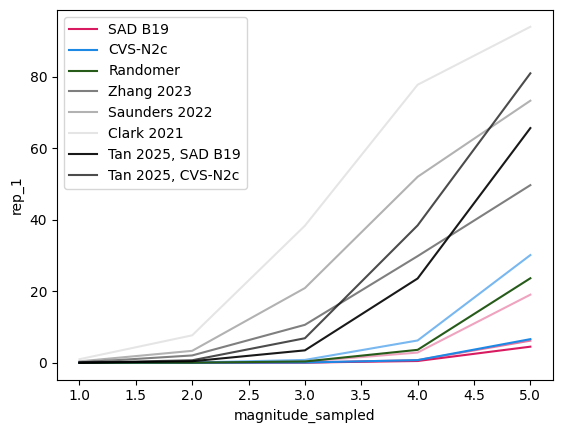

In [94]:
collision=[1,2,3,4,5]
collision=pd.DataFrame(collision)
collision.columns=['magnitude_sampled']

collision = pd.concat([collision, rep_1_collision], axis=1)
collision = pd.concat([collision, rep_2_collision], axis=1)
collision = pd.concat([collision, rep_3_collision], axis=1)
collision = pd.concat([collision, rep_4_collision], axis=1)
collision = pd.concat([collision, rep_5_collision], axis=1)
collision = pd.concat([collision, randomer_collision], axis=1)

collision = pd.concat([collision, zhang_collision], axis=1)
collision = pd.concat([collision, clark_collision], axis=1)
collision = pd.concat([collision, saunders_collision], axis=1)
collision = pd.concat([collision, tan_sad_collision], axis=1)
collision = pd.concat([collision, tan_cvs_collision], axis=1)

#Save collision dataframe to local machine
collision.to_csv('./intermediate_files/barcode_collision/barcode_collision.csv')

#Plot
sns.lineplot(data=collision, x="magnitude_sampled", y="rep_1", ci='sd', color='#d81b60',linewidth = 1.5,label='SAD B19')
sns.lineplot(data=collision, x="magnitude_sampled", y="rep_2", ci='sd', color='#d81b60',linewidth = 1.5,alpha=0.6)
sns.lineplot(data=collision, x="magnitude_sampled", y="rep_3", ci='sd', color='#d81b60',linewidth = 1.5,alpha=0.4)
sns.lineplot(data=collision, x="magnitude_sampled", y="rep_4", ci='sd', color='#1E88E5',linewidth = 1.5,label= 'CVS-N2c')
sns.lineplot(data=collision, x="magnitude_sampled", y="rep_5", ci='sd', color='#1E88E5',linewidth = 1.5,alpha=0.6)
sns.lineplot(data=collision, x="magnitude_sampled", y="randomer", ci='sd', color='#265B1A',linewidth = 1.5, label='Randomer')
sns.lineplot(data=collision, x="magnitude_sampled", y="zhang", ci='sd', color='black',linewidth = 1.5, alpha=0.5, label= 'Zhang 2023')
sns.lineplot(data=collision, x="magnitude_sampled", y="saunders", ci='sd', color='black',linewidth = 1.5,alpha=0.3, label= 'Saunders 2022')
sns.lineplot(data=collision, x="magnitude_sampled", y="clark", ci='sd', color='black',linewidth = 1.5,alpha=0.1,label='Clark 2021')
sns.lineplot(data=collision, x="magnitude_sampled", y="tan_sad", ci='sd', color='black',linewidth = 1.5,alpha=0.9,label='Tan 2025, SAD B19')
sns.lineplot(data=collision, x="magnitude_sampled", y="tan_cvs", ci='sd', color='black',linewidth = 1.5,alpha=0.7,label='Tan 2025, CVS-N2c')

plt.savefig("../../figs/fig_1/barcode_collision.pdf")
plt.legend()
plt.show()

##### Lipofectamine 2K vs Lipofectamine 3K vs HEK-GT (extended fig 1)

In [ ]:
#Concatenate dataframes
collision=[1,2,3,4,5]
collision=pd.DataFrame(collision)
collision.columns=['magnitude_sampled']
collision = pd.concat([collision, l2_1_collision], axis=1)
collision = pd.concat([collision, l2_2_collision], axis=1)
collision = pd.concat([collision, l2_3_collision], axis=1)
collision = pd.concat([collision, l2_4_collision], axis=1)

collision = pd.concat([collision, l3_1_collision], axis=1)
collision = pd.concat([collision, l3_2_collision], axis=1)
collision = pd.concat([collision, l3_3_collision], axis=1)
collision = pd.concat([collision, l3_4_collision], axis=1)

collision = pd.concat([collision, hekgt_1_collision], axis=1)
collision = pd.concat([collision, hekgt_2_collision], axis=1)
collision = pd.concat([collision, hekgt_3_collision], axis=1)
collision = pd.concat([collision, hekgt_4_collision], axis=1)

#Plot
fig, ax = plt.subplots(figsize=(6,5))
sns.lineplot(data=collision, x="magnitude_sampled", y="l2_1", ci='sd', color='black',linewidth = 1.5)
sns.lineplot(data=collision, x="magnitude_sampled", y="l2_2", ci='sd', color='black',linewidth = 1.5,alpha=0.8)
sns.lineplot(data=collision, x="magnitude_sampled", y="l2_3", ci='sd', color='black',linewidth = 1.5,alpha=0.6)
sns.lineplot(data=collision, x="magnitude_sampled", y="l2_4", ci='sd', color='black',linewidth = 1.5,alpha=0.4)

sns.lineplot(data=collision, x="magnitude_sampled", y="l3_1", ci='sd', color='blue',linewidth = 1.5)
sns.lineplot(data=collision, x="magnitude_sampled", y="l3_2", ci='sd', color='blue',linewidth = 1.5,alpha=0.8)
sns.lineplot(data=collision, x="magnitude_sampled", y="l3_3", ci='sd', color='blue',linewidth = 1.5,alpha=0.6)
sns.lineplot(data=collision, x="magnitude_sampled", y="l3_4", ci='sd', color='blue',linewidth = 1.5,alpha=0.4)

sns.lineplot(data=collision, x="magnitude_sampled", y="hekgt_1", ci='sd',color='#D81B60', linewidth = 1.5)
sns.lineplot(data=collision, x="magnitude_sampled", y="hekgt_2", ci='sd', color='#D81B60',linewidth = 1.5,alpha=0.8)
sns.lineplot(data=collision, x="magnitude_sampled", y="hekgt_3", ci='sd', color='#D81B60',linewidth = 1.5,alpha=0.6)
sns.lineplot(data=collision, x="magnitude_sampled", y="hekgt_4", ci='sd', color='#D81B60',linewidth = 1.5,alpha=0.4)

ax.figure.savefig("../../figs/sfig_1/cell_lines_and_transfection_collision.pdf")

plt.show()

##### 15cm vs 384 well plate (extended fig 1)

In [ ]:
#Concatenate dataframes
collision=[1,2,3,4,5]
collision=pd.DataFrame(collision)
collision.columns=['magnitude_sampled']
collision = pd.concat([collision, cm15_collision], axis=1)
collision = pd.concat([collision, well384_collision], axis=1)\

#Plot
fig, ax = plt.subplots(figsize=(6,5))
sns.lineplot(data=collision, x="magnitude_sampled", y="cm15", ci='sd', color='blue',linewidth = 1.5)
sns.lineplot(data=collision, x="magnitude_sampled", y="well384", ci='sd',color='#D81B60', linewidth = 1.5,alpha=0.8)
ax.figure.savefig("../../figs/sfig_1/plate_size.pdf")

plt.show()

##### Plasmid libraries (extended fig 1)

In [ ]:
#Concatenate dataframes
collision=[1,2,3,4,5]
collision=pd.DataFrame(collision)
collision.columns=['magnitude_sampled']
collision = pd.concat([collision, cvs_plasmid_collision], axis=1)
collision = pd.concat([collision, sadb19_plasmid_collision], axis=1)\

#Plot
fig, ax = plt.subplots(figsize=(6,5))
sns.lineplot(data=collision, x="magnitude_sampled", y="cvs_plasmid", ci='sd', color='blue',linewidth = 1.5)
sns.lineplot(data=collision, x="magnitude_sampled", y="sadb19_plasmid", ci='sd',color='#D81B60', linewidth = 1.5,alpha=0.8)
ax.figure.savefig("../../figs/sfig_1/plasmid_collision.pdf")

plt.show()

## Unique barcodes sampled

### Build function for simulating number of unique barcodes as a function of UMIs sampled

In [95]:
def unique_barcode_simulation(dataset, #input dataset from above)
                              umis_sampled, #number of UMIs to sample
                              bootstraps, #number of bootstrap iterations
                              output_path #path to save output matrix
                             ):
    #Expand dataset
    temp = dataset.loc[dataset.index.repeat(dataset['UMI_Count'])].reset_index(drop=True)
    
    #Randomly sample with replacement
    boot_counts=pd.DataFrame()
    for n in range(0,bootstraps):
        data=(np.random.choice(temp['barcode'],umis_sampled,replace=True))
        data=pd.Series(data).value_counts()
        data = pd.DataFrame(data)
        data.columns=['count']
        data=data.reset_index()
        boot_counts=pd.concat([boot_counts,data['count']],ignore_index=True,axis=1)
    boot_counts.to_csv(output_path)

    #Calculate mean number of barcodes
    barcode_means= [130000000000000]
    temp=boot_counts.iloc[: , 1:]
    df=temp.count()
    temp_mean=df.mean()
    barcode_means.append(temp_mean)
    barcode_means = barcode_means[1:]

    #Calculate standard deviation on mean number of barcodes
    barcode_devs = [130000000000000]
    df=temp.count()
    temp_dev=df.std()
    barcode_devs.append(temp_dev)
    barcode_devs = barcode_devs[1:]
    
    return barcode_means, barcode_devs

### Apply unique barcode simulation function to datasets of interest

This is for the main replicates and previously published studies in figure 1. The simulation is run on 10^n UMIs up to a million, where n is a whole integer. Bootstrap iterations is set to 100.

In [96]:
#Rep_1
x1_means, x1_devs = unique_barcode_simulation(rep_1, 10, 100, 
                                                        './intermediate_files/unique_barcode_simulation/rep_1_1.csv')
x2_means, x2_devs = unique_barcode_simulation(rep_1, 100, 100, 
                                                        './intermediate_files/unique_barcode_simulation/rep_1_2.csv')
x3_means, x3_devs = unique_barcode_simulation(rep_1, 1000, 100, 
                                                        './intermediate_files/unique_barcode_simulation/rep_1_3.csv')
x4_means, x4_devs = unique_barcode_simulation(rep_1, 10000, 100, 
                                                        './intermediate_files/unique_barcode_simulation/rep_1_4.csv')
x5_means, x5_devs = unique_barcode_simulation(rep_1, 100000, 100, 
                                                        './intermediate_files/unique_barcode_simulation/rep_1_5.csv')
x6_means, x6_devs = unique_barcode_simulation(rep_1, 1000000, 100, 
                                                        './intermediate_files/unique_barcode_simulation/rep_1_6.csv')

#Concatenate mean values
means=[]
means.append([x1_means,x2_means,x3_means,x4_means,x5_means,x6_means])
means=pd.DataFrame(means)
rep_1_means=means.T
rep_1_means.columns=['rep_1']


#Concatenate standard deviations
devs=[]
devs.append([x1_devs,x2_devs,x3_devs,x4_devs,x5_devs,x6_devs])
devs=pd.DataFrame(devs)
rep_1_devs=devs.T
rep_1_devs.columns=['rep_1']

In [97]:
#Rep_2
x1_means, x1_devs = unique_barcode_simulation(rep_2, 10, 100, 
                                                        './intermediate_files/unique_barcode_simulation/rep_2_1.csv')
x2_means, x2_devs = unique_barcode_simulation(rep_2, 100, 100, 
                                                        './intermediate_files/unique_barcode_simulation/rep_2_2.csv')
x3_means, x3_devs = unique_barcode_simulation(rep_2, 1000, 100, 
                                                        './intermediate_files/unique_barcode_simulation/rep_2_3.csv')
x4_means, x4_devs = unique_barcode_simulation(rep_2, 10000, 100, 
                                                        './intermediate_files/unique_barcode_simulation/rep_2_4.csv')
x5_means, x5_devs = unique_barcode_simulation(rep_2, 100000, 100, 
                                                        './intermediate_files/unique_barcode_simulation/rep_2_5.csv')
x6_means, x6_devs = unique_barcode_simulation(rep_2, 1000000, 100, 
                                                        './intermediate_files/unique_barcode_simulation/rep_2_6.csv')

#Concatenate mean values
means=[]
means.append([x1_means,x2_means,x3_means,x4_means,x5_means,x6_means])
means=pd.DataFrame(means)
rep_2_means=means.T
rep_2_means.columns=['rep_2']

#Concatenate standard deviations
devs=[]
devs.append([x1_devs,x2_devs,x3_devs,x4_devs,x5_devs,x6_devs])
devs=pd.DataFrame(devs)
rep_2_devs=devs.T
rep_2_devs.columns=['rep_2']

In [98]:
#Rep_3
x1_means, x1_devs = unique_barcode_simulation(rep_3, 10, 100, 
                                                        './intermediate_files/unique_barcode_simulation/rep_3_1.csv')
x2_means, x2_devs = unique_barcode_simulation(rep_3, 100, 100, 
                                                        './intermediate_files/unique_barcode_simulation/rep_3_2.csv')
x3_means, x3_devs = unique_barcode_simulation(rep_3, 1000, 100, 
                                                        './intermediate_files/unique_barcode_simulation/rep_3_3.csv')
x4_means, x4_devs = unique_barcode_simulation(rep_3, 10000, 100, 
                                                        './intermediate_files/unique_barcode_simulation/rep_3_4.csv')
x5_means, x5_devs = unique_barcode_simulation(rep_3, 100000, 100, 
                                                        './intermediate_files/unique_barcode_simulation/rep_3_5.csv')
x6_means, x6_devs = unique_barcode_simulation(rep_3, 1000000, 100, 
                                                        './intermediate_files/unique_barcode_simulation/rep_3_6.csv')

#Concatenate mean values
means=[]
means.append([x1_means,x2_means,x3_means,x4_means,x5_means,x6_means])
means=pd.DataFrame(means)
rep_3_means=means.T
rep_3_means.columns=['rep_3']


#Concatenate standard deviations
devs=[]
devs.append([x1_devs,x2_devs,x3_devs,x4_devs,x5_devs,x6_devs])
devs=pd.DataFrame(devs)
rep_3_devs=devs.T
rep_3_devs.columns=['rep_3']

In [99]:
#Rep_4
x1_means, x1_devs = unique_barcode_simulation(rep_4, 10, 100, 
                                                        './intermediate_files/unique_barcode_simulation/rep_4_1.csv')
x2_means, x2_devs = unique_barcode_simulation(rep_4, 100, 100, 
                                                        './intermediate_files/unique_barcode_simulation/rep_4_2.csv')
x3_means, x3_devs = unique_barcode_simulation(rep_4, 1000, 100, 
                                                        './intermediate_files/unique_barcode_simulation/rep_4_3.csv')
x4_means, x4_devs = unique_barcode_simulation(rep_4, 10000, 100, 
                                                        './intermediate_files/unique_barcode_simulation/rep_4_4.csv')
x5_means, x5_devs = unique_barcode_simulation(rep_4, 100000, 100, 
                                                        './intermediate_files/unique_barcode_simulation/rep_4_5.csv')
x6_means, x6_devs = unique_barcode_simulation(rep_4, 1000000, 100, 
                                                        './intermediate_files/unique_barcode_simulation/rep_4_6.csv')

#Concatenate mean values
means=[]
means.append([x1_means,x2_means,x3_means,x4_means,x5_means,x6_means])
means=pd.DataFrame(means)
rep_4_means=means.T
rep_4_means.columns=['rep_4']


#Concatenate standard deviations
devs=[]
devs.append([x1_devs,x2_devs,x3_devs,x4_devs,x5_devs,x6_devs])
devs=pd.DataFrame(devs)
rep_4_devs=devs.T
rep_4_devs.columns=['rep_4']

In [100]:
#Rep_5
x1_means, x1_devs = unique_barcode_simulation(rep_5, 10, 100, 
                                                        './intermediate_files/unique_barcode_simulation/rep_5_1.csv')
x2_means, x2_devs = unique_barcode_simulation(rep_5, 100, 100, 
                                                        './intermediate_files/unique_barcode_simulation/rep_5_2.csv')
x3_means, x3_devs = unique_barcode_simulation(rep_5, 1000, 100, 
                                                        './intermediate_files/unique_barcode_simulation/rep_5_3.csv')
x4_means, x4_devs = unique_barcode_simulation(rep_5, 10000, 100, 
                                                        './intermediate_files/unique_barcode_simulation/rep_5_4.csv')
x5_means, x5_devs = unique_barcode_simulation(rep_5, 100000, 100, 
                                                        './intermediate_files/unique_barcode_simulation/rep_5_5.csv')
x6_means, x6_devs = unique_barcode_simulation(rep_5, 1000000, 100, 
                                                        './intermediate_files/unique_barcode_simulation/rep_5_6.csv')

#Concatenate mean values
means=[]
means.append([x1_means,x2_means,x3_means,x4_means,x5_means,x6_means])
means=pd.DataFrame(means)
rep_5_means=means.T
rep_5_means.columns=['rep_5']


#Concatenate standard deviations
devs=[]
devs.append([x1_devs,x2_devs,x3_devs,x4_devs,x5_devs,x6_devs])
devs=pd.DataFrame(devs)
rep_5_devs=devs.T
rep_5_devs.columns=['rep_5']

In [101]:
#Rep_6
x1_means, x1_devs = unique_barcode_simulation(randomer, 10, 100, 
                                                        './intermediate_files/unique_barcode_simulation/randomer_1.csv')
x2_means, x2_devs = unique_barcode_simulation(randomer, 100, 100, 
                                                        './intermediate_files/unique_barcode_simulation/randomer_2.csv')
x3_means, x3_devs = unique_barcode_simulation(randomer, 1000, 100, 
                                                        './intermediate_files/unique_barcode_simulation/randomer_3.csv')
x4_means, x4_devs = unique_barcode_simulation(randomer, 10000, 100, 
                                                        './intermediate_files/unique_barcode_simulation/randomer_4.csv')
x5_means, x5_devs = unique_barcode_simulation(randomer, 100000, 100, 
                                                        './intermediate_files/unique_barcode_simulation/randomer_5.csv')
x6_means, x6_devs = unique_barcode_simulation(randomer, 1000000, 100, 
                                                        './intermediate_files/unique_barcode_simulation/randomer_6.csv')

#Concatenate mean values
means=[]
means.append([x1_means,x2_means,x3_means,x4_means,x5_means,x6_means])
means=pd.DataFrame(means)
randomer_means=means.T
randomer_means.columns=['randomer']


#Concatenate standard deviations
devs=[]
devs.append([x1_devs,x2_devs,x3_devs,x4_devs,x5_devs,x6_devs])
devs=pd.DataFrame(devs)
randomer_devs=devs.T
randomer_devs.columns=['randomer']

In [102]:
#Clark
x1_means, x1_devs = unique_barcode_simulation(clark, 10, 100, 
                                                        './intermediate_files/unique_barcode_simulation/clark_1.csv')
x2_means, x2_devs = unique_barcode_simulation(clark, 100, 100, 
                                                        './intermediate_files/unique_barcode_simulation/clark_2.csv')
x3_means, x3_devs = unique_barcode_simulation(clark, 1000, 100, 
                                                        './intermediate_files/unique_barcode_simulation/clark_3.csv')
x4_means, x4_devs = unique_barcode_simulation(clark, 10000, 100, 
                                                        './intermediate_files/unique_barcode_simulation/clark_4.csv')
x5_means, x5_devs = unique_barcode_simulation(clark, 100000, 100, 
                                                        './intermediate_files/unique_barcode_simulation/clark_5.csv')
x6_means, x6_devs = unique_barcode_simulation(clark, 1000000, 100, 
                                                        './intermediate_files/unique_barcode_simulation/clark_6.csv')

#Concatenate mean values
means=[]
means.append([x1_means,x2_means,x3_means,x4_means,x5_means,x6_means])
means=pd.DataFrame(means)
clark_means=means.T
clark_means.columns=['clark']


#Concatenate standard deviations
devs=[]
devs.append([x1_devs,x2_devs,x3_devs,x4_devs,x5_devs,x6_devs])
devs=pd.DataFrame(devs)
clark_devs=devs.T
clark_devs.columns=['clark']

In [103]:
#Saunders
x1_means, x1_devs = unique_barcode_simulation(saunders, 10, 100, 
                                                        './intermediate_files/unique_barcode_simulation/saunders_1.csv')
x2_means, x2_devs = unique_barcode_simulation(saunders, 100, 100, 
                                                        './intermediate_files/unique_barcode_simulation/saunders_2.csv')
x3_means, x3_devs = unique_barcode_simulation(saunders, 1000, 100, 
                                                        './intermediate_files/unique_barcode_simulation/saunders_3.csv')
x4_means, x4_devs = unique_barcode_simulation(saunders, 10000, 100, 
                                                        './intermediate_files/unique_barcode_simulation/saunders_4.csv')
x5_means, x5_devs = unique_barcode_simulation(saunders, 100000, 100, 
                                                        './intermediate_files/unique_barcode_simulation/saunders_5.csv')
x6_means, x6_devs = unique_barcode_simulation(saunders, 1000000, 100, 
                                                        './intermediate_files/unique_barcode_simulation/saunders_6.csv')

#Concatenate mean values
means=[]
means.append([x1_means,x2_means,x3_means,x4_means,x5_means,x6_means])
means=pd.DataFrame(means)
saunders_means=means.T
saunders_means.columns=['saunders']


#Concatenate standard deviations
devs=[]
devs.append([x1_devs,x2_devs,x3_devs,x4_devs,x5_devs,x6_devs])
devs=pd.DataFrame(devs)
saunders_devs=devs.T
saunders_devs.columns=['saunders']

In [104]:
#Zhang
x1_means, x1_devs = unique_barcode_simulation(zhang, 10, 100, 
                                                        './intermediate_files/unique_barcode_simulation/zhang_1.csv')
x2_means, x2_devs = unique_barcode_simulation(zhang, 100, 100, 
                                                        './intermediate_files/unique_barcode_simulation/zhang_2.csv')
x3_means, x3_devs = unique_barcode_simulation(zhang, 1000, 100, 
                                                        './intermediate_files/unique_barcode_simulation/zhang_3.csv')
x4_means, x4_devs = unique_barcode_simulation(zhang, 10000, 100, 
                                                        './intermediate_files/unique_barcode_simulation/zhang_4.csv')
x5_means, x5_devs = unique_barcode_simulation(zhang, 100000, 100, 
                                                        './intermediate_files/unique_barcode_simulation/zhang_5.csv')
x6_means, x6_devs = unique_barcode_simulation(zhang, 1000000, 100, 
                                                        './intermediate_files/unique_barcode_simulation/zhang_6.csv')

#Concatenate mean values
means=[]
means.append([x1_means,x2_means,x3_means,x4_means,x5_means,x6_means])
means=pd.DataFrame(means)
zhang_means=means.T
zhang_means.columns=['zhang']


#Concatenate standard deviations
devs=[]
devs.append([x1_devs,x2_devs,x3_devs,x4_devs,x5_devs,x6_devs])
devs=pd.DataFrame(devs)
zhang_devs=devs.T
zhang_devs.columns=['zhang']

In [105]:
#Tan
x1_means, x1_devs = unique_barcode_simulation(tan_sad, 10, 100, 
                                                        './intermediate_files/unique_barcode_simulation/tan_sad_1.csv')
x2_means, x2_devs = unique_barcode_simulation(tan_sad, 100, 100, 
                                                        './intermediate_files/unique_barcode_simulation/tan_sad_2.csv')
x3_means, x3_devs = unique_barcode_simulation(tan_sad, 1000, 100,
                                                        './intermediate_files/unique_barcode_simulation/tan_sad_3.csv')
x4_means, x4_devs = unique_barcode_simulation(tan_sad, 10000, 100, 
                                                        './intermediate_files/unique_barcode_simulation/tan_sad_4.csv')
x5_means, x5_devs = unique_barcode_simulation(tan_sad, 100000, 100, 
                                                        './intermediate_files/unique_barcode_simulation/tan_sad_5.csv')
x6_means, x6_devs = unique_barcode_simulation(tan_sad, 1000000, 100, 
                                                        './intermediate_files/unique_barcode_simulation/tan_sad_6.csv')

#Concatenate mean values
means=[]
means.append([x1_means,x2_means,x3_means,x4_means,x5_means,x6_means])
means=pd.DataFrame(means)
tan_sad_means=means.T
tan_sad_means.columns=['tan_sad']


#Concatenate standard deviations
devs=[]
devs.append([x1_devs,x2_devs,x3_devs,x4_devs,x5_devs,x6_devs])
devs=pd.DataFrame(devs)
tan_sad_devs=devs.T
tan_sad_devs.columns=['tan_sad']




#Tan
x1_means, x1_devs = unique_barcode_simulation(tan_cvs, 10, 100, 
                                                        './intermediate_files/unique_barcode_simulation/tan_cvs_1.csv')
x2_means, x2_devs = unique_barcode_simulation(tan_cvs, 100, 100, 
                                                        './intermediate_files/unique_barcode_simulation/tan_cvs_2.csv')
x3_means, x3_devs = unique_barcode_simulation(tan_cvs, 1000, 100,
                                                        './intermediate_files/unique_barcode_simulation/tan_cvs_3.csv')
x4_means, x4_devs = unique_barcode_simulation(tan_cvs, 10000, 100, 
                                                        './intermediate_files/unique_barcode_simulation/tan_cvs_4.csv')
x5_means, x5_devs = unique_barcode_simulation(tan_cvs, 100000, 100, 
                                                        './intermediate_files/unique_barcode_simulation/tan_cvs_5.csv')
x6_means, x6_devs = unique_barcode_simulation(tan_cvs, 1000000, 100, 
                                                        './intermediate_files/unique_barcode_simulation/tan_cvs_6.csv')

#Concatenate mean values
means=[]
means.append([x1_means,x2_means,x3_means,x4_means,x5_means,x6_means])
means=pd.DataFrame(means)
tan_cvs_means=means.T
tan_cvs_means.columns=['tan_cvs']


#Concatenate standard deviations
devs=[]
devs.append([x1_devs,x2_devs,x3_devs,x4_devs,x5_devs,x6_devs])
devs=pd.DataFrame(devs)
tan_cvs_devs=devs.T
tan_cvs_devs.columns=['tan_cvs']

### Concatenate all values into a single dataframe for plotting

In [107]:
#Build reads table
reads=[10,100,1000,10000,100000,1000000]
reads=pd.DataFrame(reads)

#reads=reads.T
#reads.columns=['simulated_UMIs']

#Concatenate results of all simulations together
reads = pd.concat([reads, zhang_means], axis=1, ignore_index=True)
reads = pd.concat([reads, clark_means], axis=1, ignore_index=True)
reads = pd.concat([reads, saunders_means], axis=1, ignore_index=True)
reads = pd.concat([reads, tan_cvs_means], axis=1, ignore_index=True)
reads = pd.concat([reads, tan_sad_means], axis=1, ignore_index=True)
reads = pd.concat([reads, rep_1_means], axis=1, ignore_index=True)
reads = pd.concat([reads, rep_2_means], axis=1, ignore_index=True)
reads = pd.concat([reads, rep_3_means], axis=1, ignore_index=True)
reads = pd.concat([reads, rep_4_means], axis=1, ignore_index=True)
reads = pd.concat([reads, rep_5_means], axis=1, ignore_index=True)
reads = pd.concat([reads, randomer_means], axis=1, ignore_index=True)
reads = pd.concat([reads, zhang_devs], axis=1, ignore_index=True)
reads = pd.concat([reads, clark_devs], axis=1, ignore_index=True)
reads = pd.concat([reads, saunders_devs], axis=1, ignore_index=True)
reads = pd.concat([reads, tan_cvs_devs], axis=1, ignore_index=True)
reads = pd.concat([reads, tan_sad_devs], axis=1, ignore_index=True)
reads = pd.concat([reads, rep_1_devs], axis=1, ignore_index=True)
reads = pd.concat([reads, rep_2_devs], axis=1, ignore_index=True)
reads = pd.concat([reads, rep_3_devs], axis=1, ignore_index=True)
reads = pd.concat([reads, rep_4_devs], axis=1, ignore_index=True)
reads = pd.concat([reads, rep_5_devs], axis=1, ignore_index=True)
reads = pd.concat([reads, randomer_devs], axis=1, ignore_index=True)


print(reads)

#Fill in values for a perfect dataset
ideal=[10,100,1000,10000,100000,1000000]
ideal=pd.DataFrame(ideal)
#ideal=ideal.T
idealdev=[0,0,0,0,0,0]
idealdev=pd.DataFrame(idealdev)
#idealdev=idealdev.T
reads = pd.concat([reads, ideal], axis=1, ignore_index=True)
reads = pd.concat([reads, idealdev], axis=1, ignore_index=True)

reads.columns=['simulated_UMIs','Zhang','Clark','Saunders','Tan_CVS','Tan_SAD','Rep_1','Rep_2','Rep_3','Rep_4','Rep_5','Randomer',
              'Zhang_devs','Clark_devs','Saunders_devs','Tan_CVS_devs','Tan_SAD_devs','Rep_1_devs','Rep_2_devs','Rep_3_devs','Rep_4_devs','Rep_5_devs','Randomer_devs',
              'Ideal','Ideal_devs']

#Save intermediate file prior to plotting
reads.to_csv('./intermediate_files/unique_barcode_simulation/unique_barcodes_vs_reads.csv')

        0                     1                     2                     3   \
0       10    [9.97979797979798]   [9.909090909090908]    [9.98989898989899]   
1      100   [98.05050505050505]   [92.64646464646465]   [96.39393939393939]   
2     1000   [892.1515151515151]   [616.1414141414141]   [790.7474747474747]   
3    10000   [7025.686868686868]  [2220.3939393939395]   [4796.888888888889]   
4   100000   [50356.31313131313]   [6091.161616161616]  [26727.777777777777]   
5  1000000  [194150.55555555556]   [26195.37373737374]   [174877.8282828283]   

                    4                    5                    6   \
0   [9.98989898989899]               [10.0]               [10.0]   
1   [99.3030303030303]  [99.65656565656566]              [100.0]   
2  [930.1818181818181]  [964.6868686868687]  [999.4141414141415]   
3  [6165.858585858586]  [7638.818181818182]  [9949.535353535353]   
4  [19088.49494949495]  [34401.51515151515]  [95495.48484848485]   
5  [32659.59595959596]  [72571.

### Visualize

In [108]:
#Reloading values after removing brackets
reads=pd.read_table('./intermediate_files/unique_barcode_simulation/unique_barcodes_vs_reads.csv',delimiter=',')
reads

,Unnamed: 0,simulated_UMIs,Zhang,Clark,Saunders,Tan_CVS,Tan_SAD,Rep_1,Rep_2,Rep_3,...,Tan_CVS_devs,Tan_SAD_devs,Rep_1_devs,Rep_2_devs,Rep_3_devs,Rep_4_devs,Rep_5_devs,Randomer_devs,Ideal,Ideal_devs
0,0,10,9.979798,9.909091,9.989899,9.989899,10.000000,10.000000,10.000000,10.000000,...,0.100504,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10,0
1,1,100,98.050505,92.646465,96.393939,99.303030,99.656566,100.000000,99.969697,99.959596,...,0.762040,0.556256,0.000000,0.172292,0.197907,0.000000,0.273927,0.273927,100,0
2,2,1000,892.151515,616.141414,790.747475,930.181818,964.686869,999.414141,999.000000,996.838384,...,8.427801,6.026551,0.880748,0.936777,1.799700,0.859065,2.635603,2.285624,1000,0
3,3,10000,7025.686869,2220.393939,4796.888889,6165.858586,7638.818182,9949.535354,9924.484848,9717.858586,...,40.654595,40.333903,6.797828,8.754432,18.120352,8.059278,23.030167,21.107118,10000,0
4,4,100000,50356.313130,6091.161616,26727.777780,19088.494950,34401.515150,95495.484850,93804.585860,80968.161620,...,61.542813,108.454200,64.488943,71.178564,116.678147,78.855725,154.122792,127.416179,100000,0
5,5,1000000,194150.555600,26195.373740,174877.828300,32659.595960,72571.181820,684345.010100,611788.737400,410326.484800,...,50.116786,52.393987,325.369350,345.660137,347.375829,414.089446,331.489400,353.532081,1000000,0


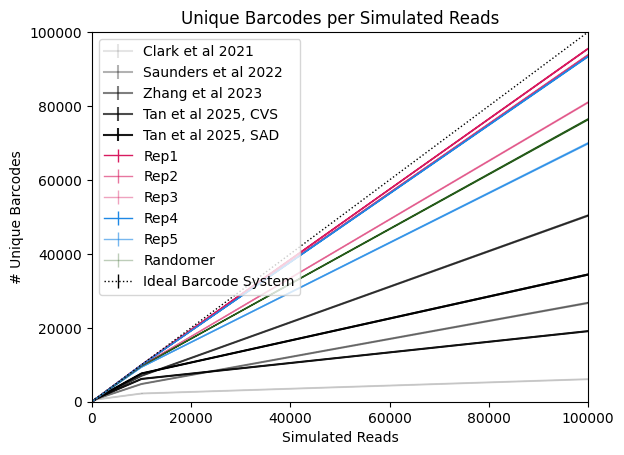

In [113]:
#Plot unique barcode per reads comparison
plt.errorbar(reads['simulated_UMIs'],reads['Clark'], yerr=reads['Clark_devs'], color = 'black',label="Clark et al 2021",alpha=0.1)
plt.errorbar(reads['simulated_UMIs'],reads['Saunders'], yerr=reads['Saunders_devs'], color = 'black',label="Saunders et al 2022",alpha=0.3)
plt.errorbar(reads['simulated_UMIs'],reads['Zhang'], yerr=reads['Zhang_devs'], color = 'black',label="Zhang et al 2023",alpha=0.5)
plt.errorbar(reads['simulated_UMIs'],reads['Tan_CVS'], yerr=reads['Tan_CVS_devs'], color = 'black',label="Tan et al 2025, CVS",alpha=0.7)
plt.errorbar(reads['simulated_UMIs'],reads['Tan_SAD'], yerr=reads['Tan_SAD_devs'], color = 'black',label="Tan et al 2025, SAD",alpha=0.9)



plt.errorbar(reads['simulated_UMIs'],reads['Rep_1'], yerr=reads['Rep_1_devs'], color = '#d81b60',label="Rep1",linewidth=1)
plt.errorbar(reads['simulated_UMIs'],reads['Rep_2'], yerr=reads['Rep_2_devs'], color = '#d81b60',label="Rep2",alpha=0.6,linewidth=1)
plt.errorbar(reads['simulated_UMIs'],reads['Rep_3'], yerr=reads['Rep_3_devs'], color = '#d81b60',label="Rep3",alpha=0.4,linewidth=1)
plt.errorbar(reads['simulated_UMIs'],reads['Rep_4'], yerr=reads['Rep_4_devs'], color = '#1E88E5',label="Rep4",linewidth=1)
plt.errorbar(reads['simulated_UMIs'],reads['Rep_5'], yerr=reads['Rep_5_devs'], color = '#1E88E5',label="Rep5",alpha=0.6,linewidth=1)
plt.errorbar(reads['simulated_UMIs'],reads['Randomer'], yerr=reads['Randomer_devs'], color = '#265B1A',label="Randomer",alpha=0.3,linewidth=1)
plt.errorbar(reads['simulated_UMIs'],reads['Ideal'], yerr=reads['Ideal_devs'], color = 'black',label="Ideal Barcode System", fmt=":",linewidth=1)


plt.fill_between(reads['simulated_UMIs'], reads['Zhang']-reads['Zhang_devs'], reads['Zhang']+reads['Zhang_devs'],color='black',alpha=0.5,linewidth=1)
plt.fill_between(reads['simulated_UMIs'], reads['Clark']-reads['Clark_devs'], reads['Clark']+reads['Clark_devs'],color='black',alpha=0.1,linewidth=1)
plt.fill_between(reads['simulated_UMIs'], reads['Saunders']-reads['Saunders_devs'], reads['Saunders']+reads['Saunders_devs'],color='black',alpha=0.3,linewidth=1)
plt.fill_between(reads['simulated_UMIs'], reads['Tan_CVS']-reads['Tan_CVS_devs'], reads['Tan_CVS']+reads['Tan_CVS_devs'],color='black',alpha=0.7,linewidth=1)
plt.fill_between(reads['simulated_UMIs'], reads['Tan_SAD']-reads['Tan_SAD_devs'], reads['Tan_SAD']+reads['Tan_SAD_devs'],color='black',alpha=0.9,linewidth=1)
plt.fill_between(reads['simulated_UMIs'], reads['Rep_1']-reads['Rep_1_devs'], reads['Rep_1']+reads['Rep_1_devs'],color='#d81b60',linewidth=1)
plt.fill_between(reads['simulated_UMIs'], reads['Rep_2']-reads['Rep_2_devs'], reads['Rep_2']+reads['Rep_2_devs'],color='#d81b60',alpha=0.6,linewidth=1)
plt.fill_between(reads['simulated_UMIs'], reads['Rep_3']-reads['Rep_3_devs'], reads['Rep_3']+reads['Rep_3_devs'],color='#d81b60',alpha=0.4,linewidth=1)
plt.fill_between(reads['simulated_UMIs'], reads['Rep_4']-reads['Rep_4_devs'], reads['Rep_4']+reads['Rep_4_devs'],color='#1E88E5',linewidth=1)
plt.fill_between(reads['simulated_UMIs'], reads['Rep_5']-reads['Rep_5_devs'], reads['Rep_5']+reads['Rep_5_devs'],color='#1E88E5',alpha=0.6,linewidth=1)
plt.fill_between(reads['simulated_UMIs'], reads['Randomer']-reads['Randomer_devs'], reads['Randomer']+reads['Randomer_devs'],color='#265B1A',linewidth=1)

plt.ylabel("# Unique Barcodes")
plt.xlabel("Simulated Reads")
plt.title("Unique Barcodes per Simulated Reads")
plt.legend()

plt.axis([0, 100000, 0, 100000])
plt.draw()
plt.savefig("../../figs/fig_1/100k_unique_barcode_simulation.pdf",bbox_inches='tight', format='pdf')
plt.show()

## Barcode entropy

### Build function for calculating Shannon entropy for each barcode library

In [114]:
# learned how to create df from nested dictionary from https://stackoverflow.com/questions/13575090/construct-pandas-dataframe-from-items-in-nested-dictionary
def flatten_dict(nested_dict):
    res = {}
    if isinstance(nested_dict, dict):
        for k in nested_dict:
            flattened_dict = flatten_dict(nested_dict[k])
            for key, val in flattened_dict.items():
                key = list(key)
                key.insert(0, k)
                res[tuple(key)] = val
    else:
        res[()] = nested_dict
    return res


def nested_dict_to_df(values_dict):
    flat_dict = flatten_dict(values_dict)
    df = pd.DataFrame.from_dict(flat_dict, orient="index")
    df.index = pd.MultiIndex.from_tuples(df.index)
    df = df.unstack(level=-1)
    df.columns = df.columns.map("{0[1]}".format)
    return df

In [115]:
# make sure datasets and datasets_names are in the same order
def shannon_entropy_calculator (datasets, dataset_names):
    
    shannon_entropy_dict = {}
    
    for dataset_name in dataset_names:
        shannon_entropy_dict[dataset_name] = {}
    
    for df in datasets:
        UMI_sum = df['UMI_Count'].sum()
        df['probability'] = df['UMI_Count'] / UMI_sum
        
        df['uniform count'] = 1
        df['uniform probability'] = df['uniform count']/UMI_sum

    i = 0
    for df in datasets:
        # print(i)
        # print(dataset_names[i])
        # print(df)
        base = 2 
        pk_non_uni = df['probability'].to_numpy(dtype ='float64')
        
        pk_uni = df['uniform probability'].to_numpy(dtype ='float32')
        
        H_non_uni = entropy(pk_non_uni, base=base)
        
        H_uni = entropy(pk_uni, base=base)
    
        shannon_entropy_dict[dataset_names[i]]['observed entropy (bits)'] = H_non_uni
        
        shannon_entropy_dict[dataset_names[i]]['entropy (bits) if library was uniform'] = H_uni
        i += 1
        
    return nested_dict_to_df(shannon_entropy_dict).reset_index().rename(columns = {'index':'dataset'})

### Calculate Shannon entropies for datasets of interest

##### All datasets in one go

In [121]:
datasets = [zhang,saunders,clark,tan_sad,tan_cvs,rep_1,rep_2,rep_3,rep_4,rep_5,randomer,
           sadb19_plasmid,cvs_plasmid,
           l2_1,l2_2,l2_3,l2_4,l3_1,l3_2,l3_3,l3_4,
           hekgt_1,hekgt_2,hekgt_3,hekgt_4,
           hek293t_1,hek293t_2,hek293t_3,hek293t_4,
           cm15,well384
           ]

dataset_names = ['zhang','saunders','clark','tan_sad','tan_cvs','rep_1','rep_2','rep_3','rep_4','rep_5','randomer',
                'sadb19_plasmid','cvs_plasmid',
                'l2_1','l2_2','l2_3','l2_4','l3_1','l3_2','l3_3','l3_4',
                'gt_1','gt_2','gt_3','gt_4','293t_1','293t_2','293t_3','293t_4',
                'cm15','well284'
                ]

df_shannon = shannon_entropy_calculator(datasets,dataset_names)

In [122]:
df_shannon['percent of maximal entropy'] = 100 * (df_shannon['observed entropy (bits)']) / (df_shannon['entropy (bits) if library was uniform'])
df_shannon

,dataset,entropy (bits) if library was uniform,observed entropy (bits),percent of maximal entropy
0,293t_1,20.328774,15.245363,74.994011
1,293t_2,20.219510,15.371320,76.022215
2,293t_3,20.830683,15.687557,75.309855
3,293t_4,21.261793,16.217797,76.276713
4,clark,18.399784,10.559668,57.390175
5,cm15,19.955081,17.759023,88.994992
6,cvs_plasmid,24.830839,24.437118,98.414388
7,gt_1,20.643716,17.318348,83.891620
8,gt_2,20.646893,17.214343,83.374983
9,gt_3,20.750023,17.392649,83.819901


##### Visualization

In [123]:
#Subset down to rows of interest
datasets=['rep_1','rep_2','rep_3','rep_4','rep_5','randomer','zhang','saunders','clark','tan_sad','tan_cvs']
main_fig=df_shannon.loc[df_shannon['dataset'].isin(datasets)]
datasets=['rep_1','rep_2','rep_3','rep_4','rep_5','randomer']
main_fig.loc[(main_fig['dataset'].isin(datasets)),'this_study'] = 'y' 
main_fig.loc[~(main_fig['dataset'].isin(datasets)),'this_study'] = 'n' 
main_fig

/var/folders/5l/rz29hct17d916rns_lvv75dw0000gn/T/ipykernel_88338/2301697053.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_fig.loc[(main_fig['dataset'].isin(datasets)),'this_study'] = 'y'


,dataset,entropy (bits) if library was uniform,observed entropy (bits),percent of maximal entropy,this_study
4,clark,18.399784,10.559668,57.390175,n
19,randomer,21.272398,18.260812,85.842753,y
20,rep_1,20.481421,20.293135,99.080701,y
21,rep_2,19.999978,19.838705,99.193634,y
22,rep_3,21.349714,18.722001,87.692046,y
23,rep_4,21.872917,20.405495,93.291147,y
24,rep_5,19.969529,17.733404,88.802318,y
26,saunders,20.302870,13.598022,66.975861,n
27,tan_cvs,15.122546,13.564956,89.700211,n
28,tan_sad,16.198120,14.836758,91.595558,n


In [124]:
#Run T-test for stats
print(st.ttest_ind([10.559668,13.598022,15.317111,13.564956,14.836758], [18.260812,20.293135,19.838705,18.722001,20.405495,17.733404]))

print(st.ttest_ind([10.559668,13.598022,15.317111,13.564956,14.836758], [18.260812,20.293135,19.838705,18.722001,20.405495,17.733404],equal_var=False))

TtestResult(statistic=-6.23530452451443, pvalue=0.00015228544760203622, df=9.0)
TtestResult(statistic=-5.949735140545461, pvalue=0.0008179293727045117, df=6.353618331183715)


/var/folders/5l/rz29hct17d916rns_lvv75dw0000gn/T/ipykernel_88338/3613366082.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(x="this_study", y="observed entropy (bits)", data=main_fig, capsize=.1, ci="sd")


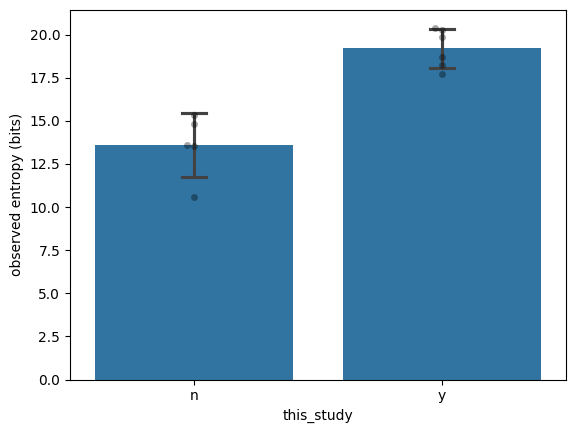

In [125]:
sns.barplot(x="this_study", y="observed entropy (bits)", data=main_fig, capsize=.1, ci="sd")
sns.swarmplot(x="this_study", y="observed entropy (bits)", data=main_fig, color="0", alpha=.35)

plt.draw()
plt.savefig("../../figs/fig_1/entropy.pdf",bbox_inches='tight', format='pdf')
plt.show()